In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
import torch
import copy
# import torch_directml
# import lightning as L

In [2]:
torch.version.cuda
print(torch.version.cuda)

None


### Feature extraction

In [2]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
# print(config['data']['frame_size'])

fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [7]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([81, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 129, 55, 80],  
                              [111, 123, 76, 84],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        n_input_channel = 1        
        self.X = np.zeros((20000, n_input_channel, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,2))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(0),num_classes=2)
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(1),num_classes=2)
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete, axis=0)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

        self.y = torch.from_numpy(self.y)
        self.X = torch.from_numpy(self.X)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.X = self.X.to(device)
        self.y = self.y.to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index,:]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  1.0


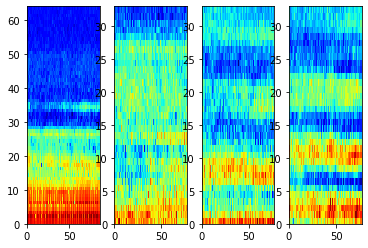

In [5]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(13202)

fig,ax = plt.subplots()
plt.subplot(141)
plt.pcolor(X_generic[0,:,:], cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)

## NN
conv_lf = torch.nn.Conv2d(1,3,(32,10),padding='valid',dtype=torch.float)

input = torch.tensor(X_generic,dtype=torch.float)
output = conv_lf(input)
output_np = output.detach().numpy()
plt.subplot(142)
plt.pcolor(output_np[0,:,:], cmap='jet')
plt.subplot(143)
plt.pcolor(output_np[1,:,:], cmap='jet')
plt.subplot(144)
plt.pcolor(output_np[2,:,:], cmap='jet')

#### CNN1-model

In [3]:
class ALS_CNN1(nn.Module):
    def __init__(self):
        super(ALS_CNN1,self).__init__() 
        # parameters
        # file = open("drive/MyDrive/Colab Notebooks/config.json")
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        input_chan = 2
        frames_in_segment = frames_in_segment - 1 # only for model with diff input
        self.layer1_filt = 4
        self.layer1_filt_hf = 4
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        # low/medium/high-frequency frequency span
        # low/medium/high-frequency time span
        lf1_height, lf1_width = 31,51 #29,43
        lf2_height, lf2_width = 19,31 #13,27
        lf3_height, lf3_width = 11,19 #5,11
        lf4_height, lf4_width = 9,11 #3,7
        lf5_height, lf5_width = 31,19

        mf1_height,mf1_width = 15,24 #15,31
        mf2_height,mf2_width =  9,15 #13,27
        mf3_height,mf3_width =  5,9
        mf4_height,mf4_width =  3,5
        # mf5_height,mf5_width =  15,9

        hf1_height,hf1_width = 15,24    
        hf2_height,hf2_width =  9,15
        hf3_height,hf3_width =  5,9 #9,15
        hf4_height,hf4_width =  3,5 #3,3
        # hf5_height,hf5_width =  15,9
        
        lf1_h_stride, lf1_w_stride = lf1_height//2, lf1_width//2
        lf2_h_stride, lf2_w_stride = lf2_height//2, lf2_width//2
        lf3_h_stride, lf3_w_stride = lf3_height//2, lf3_width//2
        lf4_h_stride, lf4_w_stride = lf4_height//2, lf4_width//2
        lf5_h_stride, lf5_w_stride = lf5_height//2, lf5_width//2

        mf1_h_stride, mf1_w_stride = mf1_height//2, mf1_width//2
        mf2_h_stride, mf2_w_stride = mf2_height//2, mf2_width//2
        mf3_h_stride, mf3_w_stride = mf3_height//2, mf3_width//2
        mf4_h_stride, mf4_w_stride = mf4_height//2, mf4_width//2
        # mf5_h_stride, mf5_w_stride = mf5_height//2, mf5_width//2

        hf1_h_stride, hf1_w_stride = hf1_height//2, hf1_width//2
        hf2_h_stride, hf2_w_stride = hf2_height//2, hf2_width//2
        hf3_h_stride, hf3_w_stride = hf3_height//2, hf3_width//2
        hf4_h_stride, hf4_w_stride = hf4_height//2, hf4_width//2
        # hf5_h_stride, hf5_w_stride = hf5_height//2, hf5_width//2

        self.batch_norm1 = nn.BatchNorm2d(input_chan)    # device='cuda'

        self.conv_lf1 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf1_height, lf1_width),padding='valid',stride=(lf1_h_stride, lf1_w_stride))
        self.conv_lf2 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf2_height, lf2_width),padding='valid',stride=(lf2_h_stride, lf2_w_stride))
        self.conv_lf3 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf3_height, lf3_width),padding='valid',stride=(lf3_h_stride, lf3_w_stride))
        self.conv_lf4 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf4_height, lf4_width),padding='valid',stride=(lf4_h_stride, lf4_w_stride))
        self.conv_lf5 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf5_height, lf5_width),padding='valid',stride=(lf5_h_stride, lf5_w_stride))

        self.conv_mf1 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf1_height, mf1_width),padding='valid',stride=(mf1_h_stride, mf1_w_stride))
        self.conv_mf2 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf2_height, mf2_width),padding='valid',stride=(mf2_h_stride, mf2_w_stride))
        self.conv_mf3 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf3_height, mf3_width),padding='valid',stride=(mf3_h_stride, mf3_w_stride))
        self.conv_mf4 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf4_height, mf4_width),padding='valid',stride=(mf4_h_stride, mf4_w_stride))
        # self.conv_mf5 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf5_height, mf5_width),padding='valid',stride=(mf5_h_stride, mf5_w_stride))

        self.conv_hf1 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf1_height, hf1_width),padding='valid',stride=(hf1_h_stride, hf1_w_stride))
        self.conv_hf2 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf2_height, hf2_width),padding='valid',stride=(hf2_h_stride, hf2_w_stride))
        self.conv_hf3 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf3_height, hf3_width),padding='valid',stride=(hf3_h_stride, hf3_w_stride))
        self.conv_hf4 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf4_height, hf4_width),padding='valid',stride=(hf4_h_stride, hf4_w_stride))

        max_pool_width = 1
        self.maxpool_lf1 = nn.MaxPool2d(((self.lf_num - lf1_height)//lf1_h_stride + 1,max_pool_width))        
        self.maxpool_lf2 = nn.MaxPool2d(((self.lf_num - lf2_height)//lf2_h_stride + 1,max_pool_width))
        self.maxpool_lf3 = nn.MaxPool2d(((self.lf_num - lf3_height)//lf3_h_stride + 1,max_pool_width))
        self.maxpool_lf4 = nn.MaxPool2d(((self.lf_num - lf4_height)//lf4_h_stride + 1,max_pool_width))
        self.maxpool_lf5 = nn.MaxPool2d(((self.lf_num - lf5_height)//lf5_h_stride + 1,max_pool_width))

        self.maxpool_mf1 = nn.MaxPool2d(((self.mf_num - mf1_height)//mf1_h_stride + 1,max_pool_width))
        self.maxpool_mf2 = nn.MaxPool2d(((self.mf_num - mf2_height)//mf2_h_stride + 1,max_pool_width))
        self.maxpool_mf3 = nn.MaxPool2d(((self.mf_num - mf3_height)//mf3_h_stride + 1,max_pool_width))
        self.maxpool_mf4 = nn.MaxPool2d(((self.mf_num - mf4_height)//mf4_h_stride + 1,max_pool_width))
        # self.maxpool_mf5 = nn.MaxPool2d(((self.mf_num - mf5_height)//mf5_h_stride + 1,max_pool_width))

        self.maxpool_hf1 = nn.MaxPool2d(((self.hf_num - hf1_height)//hf1_h_stride + 1,max_pool_width))
        self.maxpool_hf2 = nn.MaxPool2d(((self.hf_num - hf2_height)//hf2_h_stride + 1,max_pool_width))
        self.maxpool_hf3 = nn.MaxPool2d(((self.hf_num - hf3_height)//hf3_h_stride + 1,max_pool_width))
        self.maxpool_hf4 = nn.MaxPool2d(((self.hf_num - hf4_height)//hf4_h_stride + 1,max_pool_width))

        self.drop1 = nn.Dropout(p=0.1)                        

        self.fc = nn.Linear(
                            self.layer1_filt*((1+(frames_in_segment-lf1_width)//lf1_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf2_width)//lf2_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf3_width)//lf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf4_width)//lf4_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf5_width)//lf5_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf1_width)//mf1_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf2_width)//mf2_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf3_width)//mf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf4_width)//mf4_w_stride)//max_pool_width) +
                            # self.layer1_filt*((1+(frames_in_segment-mf5_width)//mf5_w_stride)//max_pool_width) +
                            self.layer1_filt_hf*((1+(frames_in_segment-hf1_width)//hf1_w_stride)//max_pool_width) +
                            self.layer1_filt_hf*((1+(frames_in_segment-hf2_width)//hf2_w_stride)//max_pool_width) + 
                            self.layer1_filt_hf*((1+(frames_in_segment-hf3_width)//hf3_w_stride)//max_pool_width) +
                            self.layer1_filt_hf*((1+(frames_in_segment-hf4_width)//hf4_w_stride)//max_pool_width)
                            ,2)                               

        torch.manual_seed(151)
        nn.init.xavier_uniform_(self.conv_lf1.weight)
        torch.manual_seed(511)
        nn.init.xavier_uniform_(self.conv_lf2.weight)
        torch.manual_seed(1511)
        nn.init.xavier_uniform_(self.conv_lf3.weight)
        torch.manual_seed(10)
        nn.init.xavier_uniform_(self.conv_lf4.weight)
        torch.manual_seed(1111)
        nn.init.xavier_uniform_(self.conv_lf5.weight)
        torch.manual_seed(111)
        nn.init.xavier_uniform_(self.conv_mf1.weight)
        torch.manual_seed(11)
        nn.init.xavier_uniform_(self.conv_mf2.weight)
        torch.manual_seed(15)
        nn.init.xavier_uniform_(self.conv_mf3.weight)
        torch.manual_seed(101)
        nn.init.xavier_uniform_(self.conv_mf4.weight)
        # torch.manual_seed(59)
        # nn.init.xavier_uniform_(self.conv_mf5.weight)
        torch.manual_seed(1115)
        nn.init.xavier_uniform_(self.conv_hf1.weight)
        torch.manual_seed(1615)
        nn.init.xavier_uniform_(self.conv_hf2.weight)
        torch.manual_seed(615)
        nn.init.xavier_uniform_(self.conv_hf3.weight)
        torch.manual_seed(110)
        nn.init.xavier_uniform_(self.conv_hf4.weight)
        # torch.manual_seed(855)
        # nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x): 
        
        # print('x size', x.shape)
        x_diff = x[:,:,:,1:] - x[:,:,:,0:-1]
        # print('x_diff', x_diff.shape)
        # print('x', x[:,:,:,1:].shape)
        out = torch.cat((x[:,:,:,1:],x_diff), dim=1)
        # print('x merge', out.shape)

        out = self.batch_norm1(out)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]
        
        out_lf2 = out1.detach()
        out_lf3 = out1.detach()
        out_lf4 = out1.detach()
        out_lf5 = out1.detach()

        out_mf2 = out2.detach()
        out_mf3 = out2.detach()
        out_mf4 = out2.detach()
        # out_mf2,out_mf3,out_mf4,out_mf5 = out2.detach(),out2.detach(),out2.detach(),out2.detach()         
        
        out_hf2 = out3.detach()
        out_hf3 = out3.detach()
        out_hf4 = out3.detach()

        # for param in self.conv_lf.parameters():
        #     print(param.data)
        #     print(param.data.shape)
        # print(self.conv_lf.weight())        
        
        
        out1 = torch.nn.functional.elu(self.conv_lf1(out1))
        out_lf2 = torch.nn.functional.elu(self.conv_lf2(out_lf2))
        out_lf3 = torch.nn.functional.elu(self.conv_lf3(out_lf3))
        out_lf4 = torch.nn.functional.elu(self.conv_lf4(out_lf4))
        out_lf5 = torch.nn.functional.elu(self.conv_lf5(out_lf5))

        out2 = torch.nn.functional.elu(self.conv_mf1(out2))
        out_mf2 = torch.nn.functional.elu(self.conv_mf2(out_mf2))
        out_mf3 = torch.nn.functional.elu(self.conv_mf3(out_mf3))
        out_mf4 = torch.nn.functional.elu(self.conv_mf4(out_mf4))
        # out_mf5 = torch.nn.functional.elu(self.conv_mf5(out_mf5))

        out3 = torch.nn.functional.elu(self.conv_hf1(out3))
        out_hf2 = torch.nn.functional.elu(self.conv_hf2(out_hf2))
        out_hf3 = torch.nn.functional.elu(self.conv_hf3(out_hf3))
        out_hf4 = torch.nn.functional.elu(self.conv_hf4(out_hf4))

        out1 = self.maxpool_lf1(out1)        
        out_lf2 = self.maxpool_lf2(out_lf2)
        out_lf3 = self.maxpool_lf3(out_lf3)
        out_lf4 = self.maxpool_lf4(out_lf4)
        out_lf5 = self.maxpool_lf5(out_lf5)

        out2 = self.maxpool_mf1(out2)
        out_mf2 = self.maxpool_mf2(out_mf2)
        out_mf3 = self.maxpool_mf3(out_mf3)
        out_mf4 = self.maxpool_mf4(out_mf4)
        # out_mf5 = self.maxpool_mf5(out_mf5)

        out3 = self.maxpool_hf1(out3)
        out_hf2 = self.maxpool_hf2(out_hf2)
        out_hf3 = self.maxpool_hf3(out_hf3)
        out_hf4 = self.maxpool_hf4(out_hf4)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out_lf2 = out_lf2.view(-1, out_lf2.shape[1]*out_lf2.shape[2]*out_lf2.shape[3])
        out_lf3 = out_lf3.view(-1, out_lf3.shape[1]*out_lf3.shape[2]*out_lf3.shape[3])
        out_lf4 = out_lf4.view(-1, out_lf4.shape[1]*out_lf4.shape[2]*out_lf4.shape[3])
        out_lf5 = out_lf5.view(-1, out_lf5.shape[1]*out_lf5.shape[2]*out_lf5.shape[3])

        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out_mf2 = out_mf2.view(-1, out_mf2.shape[1]*out_mf2.shape[2]*out_mf2.shape[3])
        out_mf3 = out_mf3.view(-1, out_mf3.shape[1]*out_mf3.shape[2]*out_mf3.shape[3])
        out_mf4 = out_mf4.view(-1, out_mf4.shape[1]*out_mf4.shape[2]*out_mf4.shape[3])
        # out_mf5 = out_mf5.view(-1, out_mf5.shape[1]*out_mf5.shape[2]*out_mf5.shape[3])

        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])
        out_hf2 = out_hf2.view(-1, out_hf2.shape[1]*out_hf2.shape[2]*out_hf2.shape[3])
        out_hf3 = out_hf3.view(-1, out_hf3.shape[1]*out_hf3.shape[2]*out_hf3.shape[3])
        out_hf4 = out_hf4.view(-1, out_hf4.shape[1]*out_hf4.shape[2]*out_hf4.shape[3])

        out = torch.cat((out1, out_lf2, out_lf3, out_lf4, out_lf5,
                         out2, out_mf2, out_mf3, out_mf4, #out_mf5,
                         out3, out_hf2, out_hf3, out_hf4
                         ), 1)  
        
        # print('fc.weight: ', self.fc.weight.shape)
        # print('out: ', out.shape)

        out = self.drop1(out)        

        out = self.fc(out)
        return out  

#### CNN2-model

In [70]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        # file = open("drive/MyDrive/Colab Notebooks/config.json")
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        layer1_filt = 1#18
        layer2_filt = 1#8
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        lf_width,  mf_width,  hf_width  = 48,15,15      # low/medium/high-frequency time span
        lf_height, mf_height, hf_height = 15,5,5        # low/medium/high-frequency frequency span

        l2_kernel_size = 2

        lf_h_stride, mf_h_stride, hf_h_stride = lf_height//2, mf_height//2, hf_height//2
        lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2,  hf_width//2,  hf_height//2

        self.batch_norm1 = nn.BatchNorm2d(1)
        
        self.batch_norm_lf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_mf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_hf = nn.BatchNorm2d(layer1_filt)

        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf = torch.nn.Conv2d(1,layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
        self.conv_mf = torch.nn.Conv2d(1,layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_hf = torch.nn.Conv2d(1,layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

        self.conv2_lf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_mf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_hf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))

        self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1 - (l2_kernel_size-1),1))

        self.drop1 = nn.Dropout(p=0.5)
        
        self.fc = nn.Linear(layer2_filt*(1+((frames_in_segment-lf_width)//lf_w_stride) - (l2_kernel_size-1)) + # *(1+(self.lf_num-lf_height)//lf_height)
                            layer2_filt*(1+((frames_in_segment-mf_width)//mf_w_stride) - (l2_kernel_size-1)) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            layer2_filt*(1+((frames_in_segment-hf_width)//hf_w_stride) - (l2_kernel_size-1)) #*(1+(self.hf_num-hf_height)//hf_height)
                            ,2)    # 16 = np.round(()/5).astype(int)                                  

        torch.manual_seed(151)
        # nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)

        nn.init.kaiming_normal_(self.conv_lf.weight)
        nn.init.kaiming_normal_(self.conv_mf.weight)
        nn.init.kaiming_normal_(self.conv_hf.weight)

        nn.init.kaiming_normal_(self.conv2_lf.weight)
        nn.init.kaiming_normal_(self.conv2_mf.weight)
        nn.init.kaiming_normal_(self.conv2_hf.weight)

        nn.init.xavier_normal_(self.fc.weight)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]

        out1 = torch.relu(self.conv_lf(out1))
        out2 = torch.relu(self.conv_mf(out2))
        out3 = torch.relu(self.conv_hf(out3))
        
        out1 = self.batch_norm_lf(out1)
        out2 = self.batch_norm_mf(out2)
        out3 = self.batch_norm_hf(out3)

        out1 = torch.relu(self.conv2_lf(out1))
        out2 = torch.relu(self.conv2_mf(out2))
        out3 = torch.relu(self.conv2_hf(out3))

        out1 = self.maxpool_lf(out1)        
        out2 = self.maxpool_mf(out2)
        out3 = self.maxpool_hf(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view 1:', out1.shape)

        out = torch.cat((out1,out2,out3), 1)  

        # print('After cat:', out.shape)

        out = self.drop1(out)

        out = self.fc(out)
        return out

#### training_loop

In [4]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/model_cnn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    lrs = []
    best_epoch = -1
    loss_val_min = 100
    for epoch in range(1,n_epochs+1):        
        model.train()        
        loss_train = 0.0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)                        
            outputs = outputs.squeeze(dim=1) # for batch train_loader 
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()            
        loss_train = loss_train / len(train_loader)

        # prediction on val set        
        loss_val = 0.0
        TP_TN_sum = 0
        total = 0
        model.eval()
        with torch.no_grad():            
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)                                
                pred = torch.squeeze(pred,1)                

                loss = loss_fn(pred, label)
                loss_val += loss.item()

                _,pred = torch.max(pred, dim=1)
                _,label = torch.max(label, dim=1)
                        
                total += len(label)

                TP_TN_sum = TP_TN_sum + torch.sum(label==pred)

        acc_val = TP_TN_sum/total
        loss_val = loss_val / len(val_loader)
        
        loss_train_history[epoch-1] = loss_train
        loss_val_history[epoch-1] = loss_val

        if loss_val < loss_val_min:
            torch.save(model.state_dict(), MODEL_PATH)            
            loss_val_min = loss_val
            best_epoch = epoch-1

        # if epoch==1 or epoch%2==0:                                                            
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train:.3f}, Val loss {loss_val:.3f}, Acc_val = {acc_val:.2f}')
        
        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()
        
    # model = torch.load(MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH))

    fig, ax = plt.subplots(figsize=(6,2.5))
    plt.rcParams.update({'font.size': 12})
    # plt.subplot(1,2,1)
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.plot(best_epoch,loss_val_min,color='red', marker='o', linewidth=1, markersize=5)
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    # plt.subplot(1,2,2)
    # plt.plot(range(len(lrs)),lrs)
    # plt.xlabel('step')
    # plt.ylabel('lr')    
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)
    return (loss_train_history,loss_val_history,loss_val_min,best_epoch)

### Single NN training & evaluation

In [27]:
# Test inference
model = ALS_CNN1()
X, y = DataSet_ALS.__getitem__(13202)
input = torch.tensor(X, dtype=torch.float)
input = input.unsqueeze(0)  # add batch dimension
print(input.shape)
y_out = model(input)
print(y_out.shape)

torch.Size([1, 1, 64, 86])
torch.Size([1, 2])


C:\Users\Admin\AppData\Local\Temp\ipykernel_12380\767754608.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(X, dtype=torch.float)


In [ ]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False) # num_workers=1

# model = ALS_FFNN()
model = ALS_CNN()
model.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

### Train with 5-fold CV

#### crossvalid

In [24]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        torch.manual_seed(707)
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    # print(layer.weight())
                    layer.reset_parameters()
                    # print(layer.weight())
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### k_fold_CV

In [5]:
def k_fold_CV(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    PATH = 'model_backup' + os.sep + 'cnn_init.pt'
    PATH_optim = 'model_backup'+os.sep+'cnn_optim_init.pt'
    PATH_lr = 'model_backup' + os.sep + 'cnn_lr_schedule_init.pt'

    torch.save(model.state_dict(), PATH)
    torch.save(optimizer.state_dict(), PATH_optim)
    torch.save(scheduler.state_dict(), PATH_lr)

    loss_train_history_list = list()
    loss_val_history_list = list()
    fold_acc = list()
    loss_val_best_hist = list()
    best_epoch_hist = list()
    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        model.load_state_dict(torch.load(PATH))
        optimizer.load_state_dict(torch.load(PATH_optim))
        scheduler.load_state_dict(torch.load(PATH_lr))

        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()        

        loss_train_history, loss_val_history,loss_val_best,best_epoch = train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        loss_train_history_list.append(loss_train_history)
        loss_val_history_list.append(loss_val_history)
        loss_val_best_hist.append(loss_val_best)
        best_epoch_hist.append(best_epoch)

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                pred = model(spec)
                # pred = torch.squeeze(pred,1)
                pred = torch.squeeze(pred)
                pred = torch.squeeze(pred)  
                label = torch.squeeze(label,0)
                
                # print('pred.shape', pred.shape)
                # print('pred', pred)
                # print('label.shape', label.shape)
                # print('label', label)

                # test_score.append(pred.numpy())
                test_score.append(pred[1].numpy())
                if pred[1]>pred[0]: #pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                    if label[1]>label[0]:
                        TP_TN_sum +=1    # TP
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0 
                    if label[0]>label[1]:
                        TP_TN_sum +=1    # TN                   
                y_true[inds_test[i]] = 1*(label[1]>label[0]) #label

                # if pred==label:
                #     TP_TN_sum +=1                
                i +=1
            fold_acc.append(TP_TN_sum/len(test_score))
            print('Acc = ', TP_TN_sum/len(test_score))

    fig, ax = plt.subplots(figsize=(12,2.5))
    plt.rcParams.update({'font.size': 10})    

    for i in folds:
        plt.subplot(1,len(folds),i+1)
        plt.plot(range(n_epochs), loss_train_history_list[i], label='Обучающий набор')
        plt.plot(range(n_epochs), loss_val_history_list[i], label='Проверочный набор')
        plt.plot(best_epoch_hist[i],loss_val_best_hist[i],color='red', marker='o', linewidth=1, markersize=5)
        plt.legend()
        plt.xlabel('Эпоха')
        plt.ylabel('Ошибка обучения')
    

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    
    print('Final results')
    print(f'{n_epochs} epochs. Acc_sk = {acc_sk:.2f} (Sens = {sensetivity:.2f} / Spec = {specificity:.2f}) {fold_acc[0]:.2f} / {fold_acc[1]:.2f} / {fold_acc[2]:.2f} / {fold_acc[3]:.2f} / {fold_acc[4]:.2f}')
    # print(f'Prec = {prec:.2f}')
    # print(f'Recall = {recall:.2f}')
    # print(f'')    
    
    # return acc_sk

#### Start script

In [ ]:
# script with reset.parameters()
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=2e-3) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = model, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

#### Start k-fold CV

In [ ]:
# dir_HC = '../wav'+ os.sep + 'HC' + os.sep
# dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()

# Start parameters
# layer1_filt = 64
# lf_num, mf_num, hf_num = 32,16,16    # low-frequency / medium-frequency / high-frequency       
# lf_width,  mf_width,  hf_width  = 12,8,4      # low/medium/high-frequency time span
# lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span
# lf_h_stride, mf_h_stride, hf_h_stride = 4,2,1
# lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2, mf_width//2, hf_width//2
# optimizer = optim.Adam(model.parameters(),lr=1e-2, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.56 (Sens = 0.47 / Spec = 0.65) 0.66 / 0.37 / 0.64 / 0.62 / 0.55
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.66) 0.65 / 0.82 / 0.72 / 0.78 / 0.61
# lf_height = 24
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.63 (Sens = 0.75 / Spec = 0.51) 0.72 / 0.71 / 0.59 / 0.63 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.61 (Sens = 0.73 / Spec = 0.49) 0.62 / 0.68 / 0.57 / 0.64 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.75 (Sens = 0.78 / Spec = 0.71) 0.68 / 0.85 / 0.66 / 0.68 / 0.87 (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 30 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.71 / 0.82 / 0.73 / 0.67 / 0.86
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.73 / 0.88 / 0.67 / 0.65 / 0.87
# mf_height = 12 (old val 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.73) 0.80 / 0.88 / 0.70 / 0.65 / 0.84
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.77 / 0.86 / 0.71 / 0.64 / 0.73
# hf_height = 12 (old val 8) 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.70) 0.67 / 0.89 / 0.65 / 0.66 / 0.810
# hf_height = 8 (return), mf_height = 16 (old val 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.71) 0.83 / 0.92 / 0.58 / 0.65 / 0.90
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 100 epochs. Acc_sk = 0.65 (Sens = 0.64 / Spec = 0.66) 0.62 / 0.73 / 0.58 / 0.72 / 0.66
# lf_width = 24 (old value 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.82 / Spec = 0.70) 0.84 / 0.93 / 0.60 / 0.64 / 0.85
# mf_width = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.77 / 0.89 / 0.59 / 0.67 / 0.91
# hf_height = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.73) 0.68 / 0.89 / 0.58 / 0.75 / 0.94
# mf_height = 15 (old value 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.70 / 0.86 / 0.57 / 0.75 / 0.94
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.64 / 0.84 / 0.55 / 0.75 / 0.85
# lf_width = 48 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.68 / 0.84 / 0.55 / 0.74 / 0.89
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 24 (return) + hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.76 / 0.87 / 0.54 / 0.69 / 0.87
# mf_height = 12 (before 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.78 (Sens = 0.82 / Spec = 0.74) 0.80 / 0.85 / 0.68 / 0.65 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.5) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.79 / 0.86 / 0.64 / 0.65 / 0.76
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.3) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.68) 0.69 / 0.67 / 0.64 / 0.67 / 0.85
# hf_height = 12 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.65 / 0.86 / 0.65 / 0.68 / 0.88
# hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.72) 0.76 / 0.86 / 0.68 / 0.65 / 0.88
# hf_height = 10 (8 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.75 / 0.85 / 0.64 / 0.66 / 0.87
# hf_height = 8 (return) + hf_width = 8 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.79 / 0.86 / 0.64 / 0.63 / 0.76
# return to model with 78% Acc
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.75 / 0.83 / 0.66 / 0.65 / 0.83
# xavier_uniform changed to kaiming_normal_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.63 / 0.88 / 0.53 / 0.75 / 0.94 (good behaviour)
# kaiming_normal_ changed to kaiming_uniform_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.75 / Spec = 0.65) 0.62 / 0.87 / 0.53 / 0.77 / 0.79
# kaiming_uniform_ 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.69) 0.65 / 0.88 / 0.53 / 0.75 / 0.95
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.69 / 0.80 / 0.54 / 0.75 / 0.93
# hf_width = 5 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.65 / 0.84 / 0.58 / 0.74 / 0.90
# xavier_uniform (return) + nn.init.xavier_uniform_(self.fc)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.67 (Sens = 0.67 / Spec = 0.66) 0.60 / 0.65 / 0.62 / 0.64 / 0.82 (slow curves)
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.69) 0.75 / 0.83 / 0.58 / 0.66 / 0.79 
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.72 / Spec = 0.67) 0.74 / 0.79 / 0.60 / 0.66 / 0.73
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.71) 0.72 / 0.88 / 0.60 / 0.66 / 0.84
# lf_width = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.77 / 0.86 / 0.67 / 0.65 / 0.83
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.73 / 0.65 / 0.74
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.79 / Spec = 0.70) 0.78 / 0.90 / 0.73 / 0.65 / 0.74
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)
# mf_height = 15 (before 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.71 / 0.65 / 0.75
# mf_width, mf_height = 13,13
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.81 / 0.94 / 0.65 / 0.65 / 0.74
# mf_width, mf_height = 15,15 (return)
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.62 (Sens = 0.60 / Spec = 0.65) 0.50 / 0.74 / 0.59 / 0.72 / 0.63
# hf_width,hf_height = 5,5
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.82 / Spec = 0.59) 0.76 / 0.91 / 0.55 / 0.65 / 0.75
# mf_height,mf_width = 15,17 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.76 / Spec = 0.66) 0.68 / 0.74 / 0.56 / 0.67 / 0.87
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.73 (Sens = 0.80 / Spec = 0.65) 0.70 / 0.77 / 0.59 / 0.67 / 0.87
# self.layer1_filt = 3 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.82 / Spec = 0.65) 0.72 / 0.82 / 0.57 / 0.74 / 0.84
# self.layer1_filt = 2 (before 3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.70) 0.70 / 0.71 / 0.60 / 0.64 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 30 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.75 / 0.79 / 0.60 / 0.65 / 0.84
# optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.65 (Sens = 0.69 / Spec = 0.61) 0.62 / 0.81 / 0.57 / 0.71 / 0.62
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.8) # 15 epochs. Acc_sk = 0.72 (Sens = 0.74 / Spec = 0.70) 0.73 / 0.80 / 0.58 / 0.65 / 0.83
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.69 / Spec = 0.69) 0.68 / 0.62 / 0.63 / 0.66 / 0.83
# add second convolution with middle freq mf_height,mf_width = 7,7
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.68 / 0.85 / 0.59 / 0.64 / 0.84
# dropout = 0.1
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.68) 0.69 / 0.87 / 0.58 / 0.67 / 0.84
# mf_height,mf_width = 7,33
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.70 (Sens = 0.78 / Spec = 0.62) 0.75 / 0.69 / 0.56 / 0.73 / 0.76 (good curves. need more iterations)

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=15)


#### Test CNN1 (5-fold CV)

Epoch 1: 100%|██████████| 125/125 [00:10<00:00, 11.65it/s]


2023-06-07 23:48:24.343456 Epoch 1, Train loss 0.671, Val loss 0.686, Acc_val = 0.60


Epoch 2: 100%|██████████| 125/125 [00:09<00:00, 12.70it/s]


2023-06-07 23:48:34.700595 Epoch 2, Train loss 0.650, Val loss 0.685, Acc_val = 0.67


Epoch 3: 100%|██████████| 125/125 [00:09<00:00, 12.67it/s]


2023-06-07 23:48:45.046482 Epoch 3, Train loss 0.631, Val loss 0.686, Acc_val = 0.71


Epoch 4: 100%|██████████| 125/125 [00:10<00:00, 11.55it/s]


2023-06-07 23:48:56.429275 Epoch 4, Train loss 0.615, Val loss 0.679, Acc_val = 0.71


Epoch 5: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s]


2023-06-07 23:49:07.408596 Epoch 5, Train loss 0.597, Val loss 0.657, Acc_val = 0.69


Epoch 6: 100%|██████████| 125/125 [00:09<00:00, 12.71it/s]


2023-06-07 23:49:17.726580 Epoch 6, Train loss 0.580, Val loss 0.660, Acc_val = 0.71


Epoch 7: 100%|██████████| 125/125 [00:09<00:00, 12.74it/s]


2023-06-07 23:49:28.039056 Epoch 7, Train loss 0.563, Val loss 0.640, Acc_val = 0.68


Epoch 8: 100%|██████████| 125/125 [00:09<00:00, 12.75it/s]


2023-06-07 23:49:38.313429 Epoch 8, Train loss 0.544, Val loss 0.644, Acc_val = 0.71


Epoch 9: 100%|██████████| 125/125 [00:09<00:00, 12.85it/s]


2023-06-07 23:49:48.521773 Epoch 9, Train loss 0.526, Val loss 0.627, Acc_val = 0.69


Epoch 10: 100%|██████████| 125/125 [00:09<00:00, 12.74it/s]


2023-06-07 23:49:58.865501 Epoch 10, Train loss 0.508, Val loss 0.628, Acc_val = 0.70


Epoch 11: 100%|██████████| 125/125 [00:09<00:00, 12.63it/s]


2023-06-07 23:50:09.244167 Epoch 11, Train loss 0.488, Val loss 0.597, Acc_val = 0.64


Epoch 12: 100%|██████████| 125/125 [00:09<00:00, 12.66it/s]


2023-06-07 23:50:19.619143 Epoch 12, Train loss 0.471, Val loss 0.614, Acc_val = 0.66


Epoch 13: 100%|██████████| 125/125 [00:09<00:00, 12.74it/s]


2023-06-07 23:50:29.949130 Epoch 13, Train loss 0.456, Val loss 0.577, Acc_val = 0.59


Epoch 14: 100%|██████████| 125/125 [00:09<00:00, 12.78it/s]


2023-06-07 23:50:40.201957 Epoch 14, Train loss 0.442, Val loss 0.586, Acc_val = 0.60


Epoch 15: 100%|██████████| 125/125 [00:09<00:00, 12.64it/s]


2023-06-07 23:50:50.575566 Epoch 15, Train loss 0.429, Val loss 0.582, Acc_val = 0.58


Epoch 16: 100%|██████████| 125/125 [00:09<00:00, 12.68it/s]


2023-06-07 23:51:00.921448 Epoch 16, Train loss 0.419, Val loss 0.585, Acc_val = 0.58


Epoch 17: 100%|██████████| 125/125 [00:09<00:00, 12.71it/s]


2023-06-07 23:51:11.243970 Epoch 17, Train loss 0.409, Val loss 0.582, Acc_val = 0.56


Epoch 18: 100%|██████████| 125/125 [00:09<00:00, 12.76it/s]


2023-06-07 23:51:21.512085 Epoch 18, Train loss 0.401, Val loss 0.582, Acc_val = 0.56


Epoch 19: 100%|██████████| 125/125 [00:09<00:00, 12.74it/s]


2023-06-07 23:51:31.811605 Epoch 19, Train loss 0.393, Val loss 0.570, Acc_val = 0.52


Epoch 20: 100%|██████████| 125/125 [00:09<00:00, 12.76it/s]


2023-06-07 23:51:42.107763 Epoch 20, Train loss 0.385, Val loss 0.582, Acc_val = 0.56


Epoch 21: 100%|██████████| 125/125 [00:09<00:00, 12.78it/s]


2023-06-07 23:51:52.384888 Epoch 21, Train loss 0.381, Val loss 0.568, Acc_val = 0.53


Epoch 22: 100%|██████████| 125/125 [00:09<00:00, 12.88it/s]


2023-06-07 23:52:02.573724 Epoch 22, Train loss 0.375, Val loss 0.579, Acc_val = 0.55


Epoch 23: 100%|██████████| 125/125 [00:09<00:00, 12.78it/s]


2023-06-07 23:52:12.835839 Epoch 23, Train loss 0.372, Val loss 0.587, Acc_val = 0.57


Epoch 24: 100%|██████████| 125/125 [00:09<00:00, 12.92it/s]


2023-06-07 23:52:22.962361 Epoch 24, Train loss 0.367, Val loss 0.575, Acc_val = 0.54


Epoch 25: 100%|██████████| 125/125 [00:09<00:00, 12.76it/s]


2023-06-07 23:52:33.259214 Epoch 25, Train loss 0.365, Val loss 0.584, Acc_val = 0.56


Epoch 26: 100%|██████████| 125/125 [00:09<00:00, 12.76it/s]


2023-06-07 23:52:43.512362 Epoch 26, Train loss 0.360, Val loss 0.591, Acc_val = 0.58


Epoch 27: 100%|██████████| 125/125 [00:09<00:00, 12.85it/s]


2023-06-07 23:52:53.743659 Epoch 27, Train loss 0.357, Val loss 0.588, Acc_val = 0.58


Epoch 28: 100%|██████████| 125/125 [00:09<00:00, 12.63it/s]


2023-06-07 23:53:04.170349 Epoch 28, Train loss 0.355, Val loss 0.598, Acc_val = 0.59


Epoch 29: 100%|██████████| 125/125 [00:10<00:00, 12.43it/s]


2023-06-07 23:53:14.715072 Epoch 29, Train loss 0.352, Val loss 0.589, Acc_val = 0.58


Epoch 30: 100%|██████████| 125/125 [00:09<00:00, 12.80it/s]


2023-06-07 23:53:24.980673 Epoch 30, Train loss 0.350, Val loss 0.591, Acc_val = 0.58


Epoch 31: 100%|██████████| 125/125 [00:09<00:00, 12.74it/s]


2023-06-07 23:53:35.279904 Epoch 31, Train loss 0.349, Val loss 0.583, Acc_val = 0.57


Epoch 32: 100%|██████████| 125/125 [00:09<00:00, 12.89it/s]


2023-06-07 23:53:45.460838 Epoch 32, Train loss 0.345, Val loss 0.586, Acc_val = 0.57


Epoch 33: 100%|██████████| 125/125 [00:09<00:00, 12.80it/s]


2023-06-07 23:53:55.703567 Epoch 33, Train loss 0.344, Val loss 0.593, Acc_val = 0.58


Epoch 34: 100%|██████████| 125/125 [00:10<00:00, 12.41it/s]


2023-06-07 23:54:06.259557 Epoch 34, Train loss 0.342, Val loss 0.595, Acc_val = 0.57


Epoch 35: 100%|██████████| 125/125 [00:09<00:00, 12.91it/s]


2023-06-07 23:54:16.425622 Epoch 35, Train loss 0.341, Val loss 0.589, Acc_val = 0.57


Epoch 36: 100%|██████████| 125/125 [00:09<00:00, 12.90it/s]


2023-06-07 23:54:26.597723 Epoch 36, Train loss 0.339, Val loss 0.600, Acc_val = 0.59


Epoch 37: 100%|██████████| 125/125 [00:09<00:00, 12.78it/s]


2023-06-07 23:54:36.898152 Epoch 37, Train loss 0.338, Val loss 0.594, Acc_val = 0.59


Epoch 38: 100%|██████████| 125/125 [00:11<00:00, 11.09it/s]


2023-06-07 23:54:48.693170 Epoch 38, Train loss 0.336, Val loss 0.604, Acc_val = 0.60


Epoch 39: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s]


2023-06-07 23:54:59.540701 Epoch 39, Train loss 0.336, Val loss 0.605, Acc_val = 0.60


Epoch 40: 100%|██████████| 125/125 [00:10<00:00, 12.16it/s]


2023-06-07 23:55:10.327251 Epoch 40, Train loss 0.335, Val loss 0.600, Acc_val = 0.59


Epoch 41: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s]


2023-06-07 23:55:21.137793 Epoch 41, Train loss 0.334, Val loss 0.600, Acc_val = 0.59


Epoch 42: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s]


2023-06-07 23:55:31.990323 Epoch 42, Train loss 0.333, Val loss 0.597, Acc_val = 0.58


Epoch 43: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s]


2023-06-07 23:55:42.859847 Epoch 43, Train loss 0.332, Val loss 0.599, Acc_val = 0.59


Epoch 44: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s]


2023-06-07 23:55:53.708377 Epoch 44, Train loss 0.330, Val loss 0.601, Acc_val = 0.59


Epoch 45: 100%|██████████| 125/125 [00:10<00:00, 12.19it/s]


2023-06-07 23:56:04.462938 Epoch 45, Train loss 0.330, Val loss 0.605, Acc_val = 0.60


Epoch 46: 100%|██████████| 125/125 [00:10<00:00, 12.16it/s]


2023-06-07 23:56:15.228495 Epoch 46, Train loss 0.329, Val loss 0.600, Acc_val = 0.60


Epoch 47: 100%|██████████| 125/125 [00:10<00:00, 12.17it/s]


2023-06-07 23:56:25.998052 Epoch 47, Train loss 0.328, Val loss 0.600, Acc_val = 0.60


Epoch 48: 100%|██████████| 125/125 [00:10<00:00, 12.32it/s]


2023-06-07 23:56:36.660641 Epoch 48, Train loss 0.328, Val loss 0.607, Acc_val = 0.61


Epoch 49: 100%|██████████| 125/125 [00:10<00:00, 12.19it/s]


2023-06-07 23:56:47.402206 Epoch 49, Train loss 0.326, Val loss 0.604, Acc_val = 0.60


Epoch 50: 100%|██████████| 125/125 [00:10<00:00, 12.24it/s]


2023-06-07 23:56:58.112781 Epoch 50, Train loss 0.326, Val loss 0.603, Acc_val = 0.61


Epoch 51: 100%|██████████| 125/125 [00:10<00:00, 12.22it/s]


2023-06-07 23:57:08.857345 Epoch 51, Train loss 0.325, Val loss 0.606, Acc_val = 0.61


Epoch 52: 100%|██████████| 125/125 [00:10<00:00, 12.27it/s]


2023-06-07 23:57:19.537929 Epoch 52, Train loss 0.323, Val loss 0.605, Acc_val = 0.61


Epoch 53: 100%|██████████| 125/125 [00:10<00:00, 12.17it/s]


2023-06-07 23:57:30.291490 Epoch 53, Train loss 0.323, Val loss 0.608, Acc_val = 0.61


Epoch 54: 100%|██████████| 125/125 [00:10<00:00, 12.33it/s]


2023-06-07 23:57:40.937086 Epoch 54, Train loss 0.324, Val loss 0.603, Acc_val = 0.61


Epoch 55: 100%|██████████| 125/125 [00:10<00:00, 12.27it/s]


2023-06-07 23:57:51.619669 Epoch 55, Train loss 0.323, Val loss 0.604, Acc_val = 0.62


Epoch 56: 100%|██████████| 125/125 [00:10<00:00, 12.28it/s]


2023-06-07 23:58:02.325245 Epoch 56, Train loss 0.323, Val loss 0.613, Acc_val = 0.62


Epoch 57: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s]


2023-06-07 23:58:13.134789 Epoch 57, Train loss 0.322, Val loss 0.608, Acc_val = 0.62


Epoch 58: 100%|██████████| 125/125 [00:10<00:00, 12.18it/s]


2023-06-07 23:58:23.886350 Epoch 58, Train loss 0.321, Val loss 0.606, Acc_val = 0.62


Epoch 59: 100%|██████████| 125/125 [00:10<00:00, 12.31it/s]


2023-06-07 23:58:34.516950 Epoch 59, Train loss 0.320, Val loss 0.607, Acc_val = 0.63


Epoch 60: 100%|██████████| 125/125 [00:10<00:00, 12.20it/s]


2023-06-07 23:58:45.238522 Epoch 60, Train loss 0.320, Val loss 0.602, Acc_val = 0.63


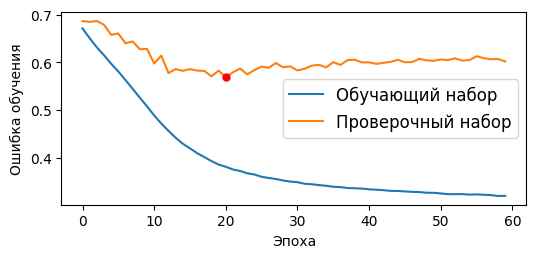

Acc =  0.8085692808819844


Epoch 1: 100%|██████████| 134/134 [00:10<00:00, 12.28it/s]


2023-06-07 23:59:08.719013 Epoch 1, Train loss 0.671, Val loss 0.667, Acc_val = 0.56


Epoch 2: 100%|██████████| 134/134 [00:11<00:00, 12.07it/s]


2023-06-07 23:59:20.037393 Epoch 2, Train loss 0.643, Val loss 0.668, Acc_val = 0.59


Epoch 3: 100%|██████████| 134/134 [00:11<00:00, 12.12it/s]


2023-06-07 23:59:31.311787 Epoch 3, Train loss 0.622, Val loss 0.668, Acc_val = 0.58


Epoch 4: 100%|██████████| 134/134 [00:11<00:00, 12.10it/s]


2023-06-07 23:59:42.603177 Epoch 4, Train loss 0.601, Val loss 0.664, Acc_val = 0.58


Epoch 5: 100%|██████████| 134/134 [00:11<00:00, 12.15it/s]


2023-06-07 23:59:53.848580 Epoch 5, Train loss 0.582, Val loss 0.657, Acc_val = 0.56


Epoch 6: 100%|██████████| 134/134 [00:11<00:00, 11.94it/s]


2023-06-08 00:00:05.297919 Epoch 6, Train loss 0.566, Val loss 0.646, Acc_val = 0.64


Epoch 7: 100%|██████████| 134/134 [00:11<00:00, 12.03it/s]


2023-06-08 00:00:16.649288 Epoch 7, Train loss 0.552, Val loss 0.637, Acc_val = 0.69


Epoch 8: 100%|██████████| 134/134 [00:11<00:00, 12.01it/s]


2023-06-08 00:00:28.019652 Epoch 8, Train loss 0.536, Val loss 0.627, Acc_val = 0.72


Epoch 9: 100%|██████████| 134/134 [00:11<00:00, 12.08it/s]


2023-06-08 00:00:39.337033 Epoch 9, Train loss 0.523, Val loss 0.620, Acc_val = 0.82


Epoch 10: 100%|██████████| 134/134 [00:11<00:00, 12.08it/s]


2023-06-08 00:00:50.640418 Epoch 10, Train loss 0.510, Val loss 0.617, Acc_val = 0.86


Epoch 11: 100%|██████████| 134/134 [00:11<00:00, 12.08it/s]


2023-06-08 00:01:01.973794 Epoch 11, Train loss 0.497, Val loss 0.610, Acc_val = 0.86


Epoch 12: 100%|██████████| 134/134 [00:11<00:00, 12.08it/s]


2023-06-08 00:01:13.280178 Epoch 12, Train loss 0.486, Val loss 0.606, Acc_val = 0.87


Epoch 13: 100%|██████████| 134/134 [00:11<00:00, 12.12it/s]


2023-06-08 00:01:24.557571 Epoch 13, Train loss 0.473, Val loss 0.601, Acc_val = 0.87


Epoch 14: 100%|██████████| 134/134 [00:11<00:00, 12.13it/s]


2023-06-08 00:01:35.868954 Epoch 14, Train loss 0.462, Val loss 0.598, Acc_val = 0.87


Epoch 15: 100%|██████████| 134/134 [00:11<00:00, 12.10it/s]


2023-06-08 00:01:47.168340 Epoch 15, Train loss 0.452, Val loss 0.608, Acc_val = 0.84


Epoch 16: 100%|██████████| 134/134 [00:11<00:00, 12.10it/s]


2023-06-08 00:01:58.457730 Epoch 16, Train loss 0.440, Val loss 0.605, Acc_val = 0.84


Epoch 17: 100%|██████████| 134/134 [00:11<00:00, 12.14it/s]


2023-06-08 00:02:09.704133 Epoch 17, Train loss 0.431, Val loss 0.602, Acc_val = 0.85


Epoch 18: 100%|██████████| 134/134 [00:11<00:00, 12.15it/s]


2023-06-08 00:02:20.950537 Epoch 18, Train loss 0.421, Val loss 0.617, Acc_val = 0.77


Epoch 19: 100%|██████████| 134/134 [00:11<00:00, 12.12it/s]


2023-06-08 00:02:32.219933 Epoch 19, Train loss 0.414, Val loss 0.608, Acc_val = 0.84


Epoch 20: 100%|██████████| 134/134 [00:11<00:00, 12.12it/s]


2023-06-08 00:02:43.502325 Epoch 20, Train loss 0.407, Val loss 0.627, Acc_val = 0.72


Epoch 21: 100%|██████████| 134/134 [00:11<00:00, 12.10it/s]


2023-06-08 00:02:54.799712 Epoch 21, Train loss 0.397, Val loss 0.635, Acc_val = 0.69


Epoch 22: 100%|██████████| 134/134 [00:11<00:00, 12.06it/s]


2023-06-08 00:03:06.125091 Epoch 22, Train loss 0.390, Val loss 0.626, Acc_val = 0.75


Epoch 23: 100%|██████████| 134/134 [00:10<00:00, 12.22it/s]


2023-06-08 00:03:17.307514 Epoch 23, Train loss 0.384, Val loss 0.649, Acc_val = 0.56


Epoch 24: 100%|██████████| 134/134 [00:11<00:00, 12.11it/s]


2023-06-08 00:03:28.584908 Epoch 24, Train loss 0.377, Val loss 0.656, Acc_val = 0.53


Epoch 25: 100%|██████████| 134/134 [00:11<00:00, 12.17it/s]


2023-06-08 00:03:39.799321 Epoch 25, Train loss 0.371, Val loss 0.654, Acc_val = 0.53


Epoch 26: 100%|██████████| 134/134 [00:11<00:00, 12.17it/s]


2023-06-08 00:03:51.032728 Epoch 26, Train loss 0.364, Val loss 0.679, Acc_val = 0.49


Epoch 27: 100%|██████████| 134/134 [00:11<00:00, 12.13it/s]


2023-06-08 00:04:02.286130 Epoch 27, Train loss 0.361, Val loss 0.691, Acc_val = 0.49


Epoch 28: 100%|██████████| 134/134 [00:10<00:00, 12.23it/s]


2023-06-08 00:04:13.453558 Epoch 28, Train loss 0.356, Val loss 0.701, Acc_val = 0.48


Epoch 29: 100%|██████████| 134/134 [00:11<00:00, 12.13it/s]


2023-06-08 00:04:24.726954 Epoch 29, Train loss 0.350, Val loss 0.706, Acc_val = 0.48


Epoch 30: 100%|██████████| 134/134 [00:10<00:00, 12.22it/s]


2023-06-08 00:04:35.905379 Epoch 30, Train loss 0.346, Val loss 0.713, Acc_val = 0.47


Epoch 31: 100%|██████████| 134/134 [00:11<00:00, 12.14it/s]


2023-06-08 00:04:47.150782 Epoch 31, Train loss 0.341, Val loss 0.723, Acc_val = 0.47


Epoch 32: 100%|██████████| 134/134 [00:10<00:00, 12.37it/s]


2023-06-08 00:04:58.193250 Epoch 32, Train loss 0.337, Val loss 0.742, Acc_val = 0.47


Epoch 33: 100%|██████████| 134/134 [00:10<00:00, 12.38it/s]


2023-06-08 00:05:09.229722 Epoch 33, Train loss 0.333, Val loss 0.728, Acc_val = 0.46


Epoch 34: 100%|██████████| 134/134 [00:10<00:00, 12.44it/s]


2023-06-08 00:05:20.258194 Epoch 34, Train loss 0.331, Val loss 0.762, Acc_val = 0.47


Epoch 35: 100%|██████████| 134/134 [00:10<00:00, 12.43it/s]


2023-06-08 00:05:31.249679 Epoch 35, Train loss 0.326, Val loss 0.776, Acc_val = 0.47


Epoch 36: 100%|██████████| 134/134 [00:10<00:00, 12.36it/s]


2023-06-08 00:05:42.298146 Epoch 36, Train loss 0.323, Val loss 0.779, Acc_val = 0.47


Epoch 37: 100%|██████████| 134/134 [00:10<00:00, 12.31it/s]


2023-06-08 00:05:53.392598 Epoch 37, Train loss 0.320, Val loss 0.817, Acc_val = 0.48


Epoch 38: 100%|██████████| 134/134 [00:10<00:00, 12.37it/s]


2023-06-08 00:06:04.434066 Epoch 38, Train loss 0.318, Val loss 0.793, Acc_val = 0.46


Epoch 39: 100%|██████████| 134/134 [00:10<00:00, 12.42it/s]


2023-06-08 00:06:15.433549 Epoch 39, Train loss 0.316, Val loss 0.841, Acc_val = 0.47


Epoch 40: 100%|██████████| 134/134 [00:10<00:00, 12.37it/s]


2023-06-08 00:06:26.478017 Epoch 40, Train loss 0.313, Val loss 0.820, Acc_val = 0.47


Epoch 41: 100%|██████████| 134/134 [00:10<00:00, 12.37it/s]


2023-06-08 00:06:37.522486 Epoch 41, Train loss 0.310, Val loss 0.832, Acc_val = 0.46


Epoch 42: 100%|██████████| 134/134 [00:10<00:00, 12.37it/s]


2023-06-08 00:06:48.565953 Epoch 42, Train loss 0.307, Val loss 0.847, Acc_val = 0.47


Epoch 43: 100%|██████████| 134/134 [00:10<00:00, 12.37it/s]


2023-06-08 00:06:59.610421 Epoch 43, Train loss 0.304, Val loss 0.853, Acc_val = 0.46


Epoch 44: 100%|██████████| 134/134 [00:10<00:00, 12.40it/s]


2023-06-08 00:07:10.626899 Epoch 44, Train loss 0.303, Val loss 0.867, Acc_val = 0.46


Epoch 45: 100%|██████████| 134/134 [00:10<00:00, 12.39it/s]


2023-06-08 00:07:21.653371 Epoch 45, Train loss 0.302, Val loss 0.869, Acc_val = 0.46


Epoch 46: 100%|██████████| 134/134 [00:10<00:00, 12.43it/s]


2023-06-08 00:07:32.640859 Epoch 46, Train loss 0.299, Val loss 0.879, Acc_val = 0.46


Epoch 47: 100%|██████████| 134/134 [00:10<00:00, 12.39it/s]


2023-06-08 00:07:43.672330 Epoch 47, Train loss 0.298, Val loss 0.901, Acc_val = 0.47


Epoch 48: 100%|██████████| 134/134 [00:10<00:00, 12.45it/s]


2023-06-08 00:07:54.649820 Epoch 48, Train loss 0.296, Val loss 0.897, Acc_val = 0.46


Epoch 49: 100%|██████████| 134/134 [00:10<00:00, 12.38it/s]


2023-06-08 00:08:05.680292 Epoch 49, Train loss 0.295, Val loss 0.877, Acc_val = 0.45


Epoch 50: 100%|██████████| 134/134 [00:10<00:00, 12.41it/s]


2023-06-08 00:08:16.733758 Epoch 50, Train loss 0.294, Val loss 0.881, Acc_val = 0.45


Epoch 51: 100%|██████████| 134/134 [00:10<00:00, 12.40it/s]


2023-06-08 00:08:27.746235 Epoch 51, Train loss 0.292, Val loss 0.934, Acc_val = 0.46


Epoch 52: 100%|██████████| 134/134 [00:10<00:00, 12.36it/s]


2023-06-08 00:08:38.792703 Epoch 52, Train loss 0.292, Val loss 0.946, Acc_val = 0.47


Epoch 53: 100%|██████████| 134/134 [00:10<00:00, 12.45it/s]


2023-06-08 00:08:49.759195 Epoch 53, Train loss 0.289, Val loss 0.927, Acc_val = 0.46


Epoch 54: 100%|██████████| 134/134 [00:11<00:00, 12.02it/s]


2023-06-08 00:09:01.114564 Epoch 54, Train loss 0.288, Val loss 0.957, Acc_val = 0.46


Epoch 55: 100%|██████████| 134/134 [00:10<00:00, 12.42it/s]


2023-06-08 00:09:12.113047 Epoch 55, Train loss 0.287, Val loss 0.946, Acc_val = 0.46


Epoch 56: 100%|██████████| 134/134 [00:10<00:00, 12.43it/s]


2023-06-08 00:09:23.099533 Epoch 56, Train loss 0.287, Val loss 0.945, Acc_val = 0.45


Epoch 57: 100%|██████████| 134/134 [00:10<00:00, 12.47it/s]


2023-06-08 00:09:34.058029 Epoch 57, Train loss 0.284, Val loss 0.969, Acc_val = 0.46


Epoch 58: 100%|██████████| 134/134 [00:10<00:00, 12.30it/s]


2023-06-08 00:09:45.159478 Epoch 58, Train loss 0.284, Val loss 0.964, Acc_val = 0.45


Epoch 59: 100%|██████████| 134/134 [00:10<00:00, 12.27it/s]


2023-06-08 00:09:56.291918 Epoch 59, Train loss 0.284, Val loss 0.988, Acc_val = 0.46


Epoch 60: 100%|██████████| 134/134 [00:10<00:00, 12.44it/s]


2023-06-08 00:10:07.269408 Epoch 60, Train loss 0.284, Val loss 0.956, Acc_val = 0.45


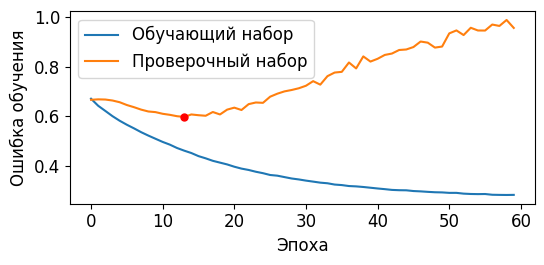

Acc =  0.7887024344126684


Epoch 1: 100%|██████████| 127/127 [00:10<00:00, 12.33it/s]


2023-06-08 00:10:30.691917 Epoch 1, Train loss 0.658, Val loss 0.674, Acc_val = 0.65


Epoch 2: 100%|██████████| 127/127 [00:10<00:00, 12.29it/s]


2023-06-08 00:10:41.385497 Epoch 2, Train loss 0.621, Val loss 0.683, Acc_val = 0.64


Epoch 3: 100%|██████████| 127/127 [00:10<00:00, 12.34it/s]


2023-06-08 00:10:52.038090 Epoch 3, Train loss 0.592, Val loss 0.681, Acc_val = 0.65


Epoch 4: 100%|██████████| 127/127 [00:10<00:00, 12.25it/s]


2023-06-08 00:11:02.769659 Epoch 4, Train loss 0.567, Val loss 0.691, Acc_val = 0.63


Epoch 5: 100%|██████████| 127/127 [00:10<00:00, 12.34it/s]


2023-06-08 00:11:13.425251 Epoch 5, Train loss 0.545, Val loss 0.699, Acc_val = 0.63


Epoch 6: 100%|██████████| 127/127 [00:10<00:00, 12.29it/s]


2023-06-08 00:11:24.120830 Epoch 6, Train loss 0.524, Val loss 0.705, Acc_val = 0.63


Epoch 7: 100%|██████████| 127/127 [00:10<00:00, 12.38it/s]


2023-06-08 00:11:34.740435 Epoch 7, Train loss 0.503, Val loss 0.712, Acc_val = 0.62


Epoch 8: 100%|██████████| 127/127 [00:10<00:00, 12.31it/s]


2023-06-08 00:11:45.416021 Epoch 8, Train loss 0.486, Val loss 0.711, Acc_val = 0.64


Epoch 9: 100%|██████████| 127/127 [00:10<00:00, 12.37it/s]


2023-06-08 00:11:56.044621 Epoch 9, Train loss 0.470, Val loss 0.714, Acc_val = 0.64


Epoch 10: 100%|██████████| 127/127 [00:10<00:00, 12.30it/s]


2023-06-08 00:12:06.729204 Epoch 10, Train loss 0.454, Val loss 0.711, Acc_val = 0.66


Epoch 11: 100%|██████████| 127/127 [00:10<00:00, 12.40it/s]


2023-06-08 00:12:17.336812 Epoch 11, Train loss 0.439, Val loss 0.719, Acc_val = 0.63


Epoch 12: 100%|██████████| 127/127 [00:10<00:00, 12.27it/s]


2023-06-08 00:12:28.046387 Epoch 12, Train loss 0.426, Val loss 0.717, Acc_val = 0.64


Epoch 13: 100%|██████████| 127/127 [00:10<00:00, 12.31it/s]


2023-06-08 00:12:38.788951 Epoch 13, Train loss 0.414, Val loss 0.713, Acc_val = 0.66


Epoch 14: 100%|██████████| 127/127 [00:10<00:00, 12.36it/s]


2023-06-08 00:12:49.424550 Epoch 14, Train loss 0.403, Val loss 0.701, Acc_val = 0.70


Epoch 15: 100%|██████████| 127/127 [00:10<00:00, 12.33it/s]


2023-06-08 00:13:00.101136 Epoch 15, Train loss 0.395, Val loss 0.702, Acc_val = 0.68


Epoch 16: 100%|██████████| 127/127 [00:10<00:00, 12.35it/s]


2023-06-08 00:13:10.747731 Epoch 16, Train loss 0.385, Val loss 0.699, Acc_val = 0.67


Epoch 17: 100%|██████████| 127/127 [00:10<00:00, 12.21it/s]


2023-06-08 00:13:21.505291 Epoch 17, Train loss 0.378, Val loss 0.692, Acc_val = 0.70


Epoch 18: 100%|██████████| 127/127 [00:10<00:00, 12.39it/s]


2023-06-08 00:13:32.111899 Epoch 18, Train loss 0.370, Val loss 0.689, Acc_val = 0.70


Epoch 19: 100%|██████████| 127/127 [00:10<00:00, 12.32it/s]


2023-06-08 00:13:42.785486 Epoch 19, Train loss 0.363, Val loss 0.686, Acc_val = 0.70


Epoch 20: 100%|██████████| 127/127 [00:10<00:00, 12.45it/s]


2023-06-08 00:13:53.344109 Epoch 20, Train loss 0.358, Val loss 0.675, Acc_val = 0.74


Epoch 21: 100%|██████████| 127/127 [00:10<00:00, 12.35it/s]


2023-06-08 00:14:03.982706 Epoch 21, Train loss 0.352, Val loss 0.678, Acc_val = 0.70


Epoch 22: 100%|██████████| 127/127 [00:10<00:00, 12.45it/s]


2023-06-08 00:14:14.545329 Epoch 22, Train loss 0.347, Val loss 0.677, Acc_val = 0.70


Epoch 23: 100%|██████████| 127/127 [00:10<00:00, 12.35it/s]


2023-06-08 00:14:25.192923 Epoch 23, Train loss 0.343, Val loss 0.667, Acc_val = 0.73


Epoch 24: 100%|██████████| 127/127 [00:10<00:00, 12.41it/s]


2023-06-08 00:14:35.793533 Epoch 24, Train loss 0.338, Val loss 0.666, Acc_val = 0.72


Epoch 25: 100%|██████████| 127/127 [00:10<00:00, 12.31it/s]


2023-06-08 00:14:46.468119 Epoch 25, Train loss 0.334, Val loss 0.657, Acc_val = 0.75


Epoch 26: 100%|██████████| 127/127 [00:10<00:00, 12.45it/s]


2023-06-08 00:14:57.033740 Epoch 26, Train loss 0.331, Val loss 0.654, Acc_val = 0.76


Epoch 27: 100%|██████████| 127/127 [00:10<00:00, 12.35it/s]


2023-06-08 00:15:07.686334 Epoch 27, Train loss 0.327, Val loss 0.648, Acc_val = 0.77


Epoch 28: 100%|██████████| 127/127 [00:10<00:00, 12.39it/s]


2023-06-08 00:15:18.350924 Epoch 28, Train loss 0.324, Val loss 0.657, Acc_val = 0.71


Epoch 29: 100%|██████████| 127/127 [00:10<00:00, 12.37it/s]


2023-06-08 00:15:28.979525 Epoch 29, Train loss 0.322, Val loss 0.642, Acc_val = 0.78


Epoch 30: 100%|██████████| 127/127 [00:10<00:00, 12.34it/s]


2023-06-08 00:15:39.636116 Epoch 30, Train loss 0.319, Val loss 0.651, Acc_val = 0.73


Epoch 31: 100%|██████████| 127/127 [00:10<00:00, 12.37it/s]


2023-06-08 00:15:50.260718 Epoch 31, Train loss 0.316, Val loss 0.640, Acc_val = 0.77


Epoch 32: 100%|██████████| 127/127 [00:10<00:00, 12.32it/s]


2023-06-08 00:16:00.932305 Epoch 32, Train loss 0.314, Val loss 0.638, Acc_val = 0.76


Epoch 33: 100%|██████████| 127/127 [00:10<00:00, 12.38it/s]


2023-06-08 00:16:11.555908 Epoch 33, Train loss 0.311, Val loss 0.631, Acc_val = 0.78


Epoch 34: 100%|██████████| 127/127 [00:10<00:00, 12.35it/s]


2023-06-08 00:16:22.197506 Epoch 34, Train loss 0.310, Val loss 0.636, Acc_val = 0.76


Epoch 35: 100%|██████████| 127/127 [00:10<00:00, 12.45it/s]


2023-06-08 00:16:32.762127 Epoch 35, Train loss 0.308, Val loss 0.634, Acc_val = 0.75


Epoch 36: 100%|██████████| 127/127 [00:10<00:00, 12.35it/s]


2023-06-08 00:16:43.403723 Epoch 36, Train loss 0.306, Val loss 0.626, Acc_val = 0.77


Epoch 37: 100%|██████████| 127/127 [00:10<00:00, 12.40it/s]


2023-06-08 00:16:54.056317 Epoch 37, Train loss 0.303, Val loss 0.627, Acc_val = 0.76


Epoch 38: 100%|██████████| 127/127 [00:10<00:00, 12.36it/s]


2023-06-08 00:17:04.685917 Epoch 38, Train loss 0.301, Val loss 0.618, Acc_val = 0.79


Epoch 39: 100%|██████████| 127/127 [00:10<00:00, 11.63it/s]


2023-06-08 00:17:16.037287 Epoch 39, Train loss 0.300, Val loss 0.624, Acc_val = 0.76


Epoch 40: 100%|██████████| 127/127 [00:13<00:00,  9.47it/s]


2023-06-08 00:17:29.889857 Epoch 40, Train loss 0.298, Val loss 0.621, Acc_val = 0.76


Epoch 41: 100%|██████████| 127/127 [00:11<00:00, 11.23it/s]


2023-06-08 00:17:41.561125 Epoch 41, Train loss 0.297, Val loss 0.631, Acc_val = 0.72


Epoch 42: 100%|██████████| 127/127 [00:10<00:00, 12.29it/s]


2023-06-08 00:17:52.250706 Epoch 42, Train loss 0.297, Val loss 0.620, Acc_val = 0.75


Epoch 43: 100%|██████████| 127/127 [00:10<00:00, 12.43it/s]


2023-06-08 00:18:02.826324 Epoch 43, Train loss 0.293, Val loss 0.617, Acc_val = 0.75


Epoch 44: 100%|██████████| 127/127 [00:10<00:00, 12.36it/s]


2023-06-08 00:18:13.458924 Epoch 44, Train loss 0.293, Val loss 0.617, Acc_val = 0.75


Epoch 45: 100%|██████████| 127/127 [00:10<00:00, 12.41it/s]


2023-06-08 00:18:24.052536 Epoch 45, Train loss 0.292, Val loss 0.607, Acc_val = 0.78


Epoch 46: 100%|██████████| 127/127 [00:10<00:00, 12.39it/s]


2023-06-08 00:18:34.650147 Epoch 46, Train loss 0.290, Val loss 0.611, Acc_val = 0.76


Epoch 47: 100%|██████████| 127/127 [00:10<00:00, 12.43it/s]


2023-06-08 00:18:45.227764 Epoch 47, Train loss 0.290, Val loss 0.605, Acc_val = 0.77


Epoch 48: 100%|██████████| 127/127 [00:10<00:00, 12.38it/s]


2023-06-08 00:18:55.838371 Epoch 48, Train loss 0.288, Val loss 0.611, Acc_val = 0.75


Epoch 49: 100%|██████████| 127/127 [00:10<00:00, 12.37it/s]


2023-06-08 00:19:06.459974 Epoch 49, Train loss 0.288, Val loss 0.609, Acc_val = 0.75


Epoch 50: 100%|██████████| 127/127 [00:10<00:00, 12.45it/s]


2023-06-08 00:19:17.017598 Epoch 50, Train loss 0.286, Val loss 0.611, Acc_val = 0.74


Epoch 51: 100%|██████████| 127/127 [00:10<00:00, 12.38it/s]


2023-06-08 00:19:27.624205 Epoch 51, Train loss 0.286, Val loss 0.608, Acc_val = 0.74


Epoch 52: 100%|██████████| 127/127 [00:10<00:00, 12.45it/s]


2023-06-08 00:19:38.183829 Epoch 52, Train loss 0.285, Val loss 0.607, Acc_val = 0.74


Epoch 53: 100%|██████████| 127/127 [00:10<00:00, 12.39it/s]


2023-06-08 00:19:48.791436 Epoch 53, Train loss 0.284, Val loss 0.603, Acc_val = 0.75


Epoch 54: 100%|██████████| 127/127 [00:10<00:00, 12.43it/s]


2023-06-08 00:19:59.365055 Epoch 54, Train loss 0.283, Val loss 0.602, Acc_val = 0.75


Epoch 55: 100%|██████████| 127/127 [00:10<00:00, 12.44it/s]


2023-06-08 00:20:09.939673 Epoch 55, Train loss 0.282, Val loss 0.598, Acc_val = 0.76


Epoch 56: 100%|██████████| 127/127 [00:10<00:00, 12.52it/s]


2023-06-08 00:20:20.439315 Epoch 56, Train loss 0.282, Val loss 0.596, Acc_val = 0.76


Epoch 57: 100%|██████████| 127/127 [00:10<00:00, 12.41it/s]


2023-06-08 00:20:31.028928 Epoch 57, Train loss 0.280, Val loss 0.600, Acc_val = 0.74


Epoch 58: 100%|██████████| 127/127 [00:10<00:00, 12.32it/s]


2023-06-08 00:20:41.690520 Epoch 58, Train loss 0.280, Val loss 0.598, Acc_val = 0.74


Epoch 59: 100%|██████████| 127/127 [00:10<00:00, 12.46it/s]


2023-06-08 00:20:52.232148 Epoch 59, Train loss 0.278, Val loss 0.593, Acc_val = 0.76


Epoch 60: 100%|██████████| 127/127 [00:10<00:00, 12.39it/s]


2023-06-08 00:21:02.836757 Epoch 60, Train loss 0.279, Val loss 0.596, Acc_val = 0.74


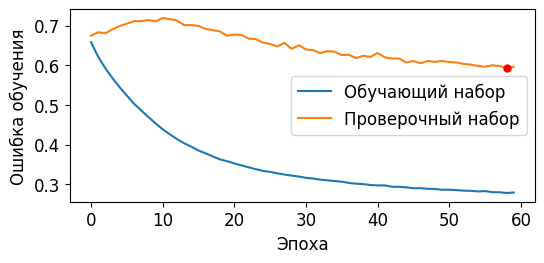

Acc =  0.6263812154696132


Epoch 1: 100%|██████████| 137/137 [00:11<00:00, 12.26it/s]


2023-06-08 00:21:27.243951 Epoch 1, Train loss 0.666, Val loss 0.670, Acc_val = 0.63


Epoch 2: 100%|██████████| 137/137 [00:11<00:00, 12.14it/s]


2023-06-08 00:21:38.827246 Epoch 2, Train loss 0.634, Val loss 0.635, Acc_val = 0.72


Epoch 3: 100%|██████████| 137/137 [00:11<00:00, 12.10it/s]


2023-06-08 00:21:50.446531 Epoch 3, Train loss 0.611, Val loss 0.608, Acc_val = 0.72


Epoch 4: 100%|██████████| 137/137 [00:11<00:00, 12.17it/s]


2023-06-08 00:22:01.999836 Epoch 4, Train loss 0.590, Val loss 0.588, Acc_val = 0.71


Epoch 5: 100%|██████████| 137/137 [00:11<00:00, 12.17it/s]


2023-06-08 00:22:13.558140 Epoch 5, Train loss 0.571, Val loss 0.566, Acc_val = 0.71


Epoch 6: 100%|██████████| 137/137 [00:11<00:00, 12.17it/s]


2023-06-08 00:22:25.111445 Epoch 6, Train loss 0.553, Val loss 0.545, Acc_val = 0.72


Epoch 7: 100%|██████████| 137/137 [00:11<00:00, 12.15it/s]


2023-06-08 00:22:36.680745 Epoch 7, Train loss 0.537, Val loss 0.521, Acc_val = 0.75


Epoch 8: 100%|██████████| 137/137 [00:11<00:00, 12.15it/s]


2023-06-08 00:22:48.247046 Epoch 8, Train loss 0.521, Val loss 0.504, Acc_val = 0.76


Epoch 9: 100%|██████████| 137/137 [00:11<00:00, 12.19it/s]


2023-06-08 00:22:59.780358 Epoch 9, Train loss 0.504, Val loss 0.483, Acc_val = 0.79


Epoch 10: 100%|██████████| 137/137 [00:11<00:00, 12.14it/s]


2023-06-08 00:23:11.363653 Epoch 10, Train loss 0.488, Val loss 0.466, Acc_val = 0.81


Epoch 11: 100%|██████████| 137/137 [00:11<00:00, 12.13it/s]


2023-06-08 00:23:22.957945 Epoch 11, Train loss 0.472, Val loss 0.436, Acc_val = 0.89


Epoch 12: 100%|██████████| 137/137 [00:11<00:00, 12.20it/s]


2023-06-08 00:23:34.485259 Epoch 12, Train loss 0.457, Val loss 0.412, Acc_val = 0.92


Epoch 13: 100%|██████████| 137/137 [00:11<00:00, 12.07it/s]


2023-06-08 00:23:46.141531 Epoch 13, Train loss 0.441, Val loss 0.391, Acc_val = 0.95


Epoch 14: 100%|██████████| 137/137 [00:11<00:00, 12.19it/s]


2023-06-08 00:23:57.675843 Epoch 14, Train loss 0.427, Val loss 0.363, Acc_val = 0.99


Epoch 15: 100%|██████████| 137/137 [00:11<00:00, 11.88it/s]


2023-06-08 00:24:09.500061 Epoch 15, Train loss 0.412, Val loss 0.345, Acc_val = 0.99


Epoch 16: 100%|██████████| 137/137 [00:11<00:00, 12.11it/s]


2023-06-08 00:24:21.108349 Epoch 16, Train loss 0.399, Val loss 0.329, Acc_val = 1.00


Epoch 17: 100%|██████████| 137/137 [00:11<00:00, 12.17it/s]


2023-06-08 00:24:32.662654 Epoch 17, Train loss 0.386, Val loss 0.312, Acc_val = 1.00


Epoch 18: 100%|██████████| 137/137 [00:11<00:00, 12.17it/s]


2023-06-08 00:24:44.220957 Epoch 18, Train loss 0.376, Val loss 0.298, Acc_val = 1.00


Epoch 19: 100%|██████████| 137/137 [00:11<00:00, 12.26it/s]


2023-06-08 00:24:55.695288 Epoch 19, Train loss 0.365, Val loss 0.284, Acc_val = 1.00


Epoch 20: 100%|██████████| 137/137 [00:11<00:00, 11.92it/s]


2023-06-08 00:25:07.479519 Epoch 20, Train loss 0.354, Val loss 0.271, Acc_val = 1.00


Epoch 21: 100%|██████████| 137/137 [00:11<00:00, 12.26it/s]


2023-06-08 00:25:18.947852 Epoch 21, Train loss 0.345, Val loss 0.263, Acc_val = 1.00


Epoch 22: 100%|██████████| 137/137 [00:11<00:00, 12.20it/s]


2023-06-08 00:25:30.469167 Epoch 22, Train loss 0.336, Val loss 0.248, Acc_val = 1.00


Epoch 23: 100%|██████████| 137/137 [00:11<00:00, 12.10it/s]


2023-06-08 00:25:42.084452 Epoch 23, Train loss 0.329, Val loss 0.243, Acc_val = 1.00


Epoch 24: 100%|██████████| 137/137 [00:11<00:00, 12.16it/s]


2023-06-08 00:25:53.644756 Epoch 24, Train loss 0.321, Val loss 0.234, Acc_val = 1.00


Epoch 25: 100%|██████████| 137/137 [00:11<00:00, 12.18it/s]


2023-06-08 00:26:05.199061 Epoch 25, Train loss 0.315, Val loss 0.230, Acc_val = 1.00


Epoch 26: 100%|██████████| 137/137 [00:11<00:00, 12.10it/s]


2023-06-08 00:26:16.820344 Epoch 26, Train loss 0.309, Val loss 0.226, Acc_val = 1.00


Epoch 27: 100%|██████████| 137/137 [00:11<00:00, 12.25it/s]


2023-06-08 00:26:28.290676 Epoch 27, Train loss 0.302, Val loss 0.226, Acc_val = 1.00


Epoch 28: 100%|██████████| 137/137 [00:11<00:00, 12.24it/s]


2023-06-08 00:26:39.794996 Epoch 28, Train loss 0.296, Val loss 0.215, Acc_val = 1.00


Epoch 29: 100%|██████████| 137/137 [00:11<00:00, 12.37it/s]


2023-06-08 00:26:51.164361 Epoch 29, Train loss 0.292, Val loss 0.216, Acc_val = 1.00


Epoch 30: 100%|██████████| 137/137 [00:11<00:00, 12.18it/s]


2023-06-08 00:27:02.707669 Epoch 30, Train loss 0.287, Val loss 0.216, Acc_val = 1.00


Epoch 31: 100%|██████████| 137/137 [00:11<00:00, 12.21it/s]


2023-06-08 00:27:14.221987 Epoch 31, Train loss 0.282, Val loss 0.209, Acc_val = 1.00


Epoch 32: 100%|██████████| 137/137 [00:11<00:00, 12.22it/s]


2023-06-08 00:27:25.725308 Epoch 32, Train loss 0.278, Val loss 0.204, Acc_val = 1.00


Epoch 33: 100%|██████████| 137/137 [00:11<00:00, 12.24it/s]


2023-06-08 00:27:37.207636 Epoch 33, Train loss 0.275, Val loss 0.208, Acc_val = 1.00


Epoch 34: 100%|██████████| 137/137 [00:11<00:00, 12.25it/s]


2023-06-08 00:27:48.690964 Epoch 34, Train loss 0.271, Val loss 0.206, Acc_val = 1.00


Epoch 35: 100%|██████████| 137/137 [00:11<00:00, 12.23it/s]


2023-06-08 00:28:00.183288 Epoch 35, Train loss 0.268, Val loss 0.207, Acc_val = 1.00


Epoch 36: 100%|██████████| 137/137 [00:11<00:00, 12.34it/s]


2023-06-08 00:28:11.581643 Epoch 36, Train loss 0.264, Val loss 0.204, Acc_val = 1.00


Epoch 37: 100%|██████████| 137/137 [00:11<00:00, 12.25it/s]


2023-06-08 00:28:23.057973 Epoch 37, Train loss 0.261, Val loss 0.210, Acc_val = 1.00


Epoch 38: 100%|██████████| 137/137 [00:11<00:00, 12.24it/s]


2023-06-08 00:28:34.552297 Epoch 38, Train loss 0.259, Val loss 0.202, Acc_val = 1.00


Epoch 39: 100%|██████████| 137/137 [00:11<00:00, 12.28it/s]


2023-06-08 00:28:46.006634 Epoch 39, Train loss 0.257, Val loss 0.203, Acc_val = 1.00


Epoch 40: 100%|██████████| 137/137 [00:11<00:00, 12.21it/s]


2023-06-08 00:28:57.514954 Epoch 40, Train loss 0.253, Val loss 0.203, Acc_val = 1.00


Epoch 41: 100%|██████████| 137/137 [00:11<00:00, 12.23it/s]


2023-06-08 00:29:09.012277 Epoch 41, Train loss 0.251, Val loss 0.207, Acc_val = 1.00


Epoch 42: 100%|██████████| 137/137 [00:11<00:00, 12.33it/s]


2023-06-08 00:29:20.414630 Epoch 42, Train loss 0.248, Val loss 0.203, Acc_val = 1.00


Epoch 43: 100%|██████████| 137/137 [00:11<00:00, 12.31it/s]


2023-06-08 00:29:31.829980 Epoch 43, Train loss 0.246, Val loss 0.202, Acc_val = 1.00


Epoch 44: 100%|██████████| 137/137 [00:11<00:00, 12.36it/s]


2023-06-08 00:29:43.206342 Epoch 44, Train loss 0.244, Val loss 0.204, Acc_val = 1.00


Epoch 45: 100%|██████████| 137/137 [00:11<00:00, 12.25it/s]


2023-06-08 00:29:54.679673 Epoch 45, Train loss 0.243, Val loss 0.208, Acc_val = 1.00


Epoch 46: 100%|██████████| 137/137 [00:11<00:00, 12.28it/s]


2023-06-08 00:30:06.134009 Epoch 46, Train loss 0.241, Val loss 0.199, Acc_val = 1.00


Epoch 47: 100%|██████████| 137/137 [00:11<00:00, 12.29it/s]


2023-06-08 00:30:17.571352 Epoch 47, Train loss 0.237, Val loss 0.206, Acc_val = 1.00


Epoch 48: 100%|██████████| 137/137 [00:11<00:00, 12.27it/s]


2023-06-08 00:30:29.020690 Epoch 48, Train loss 0.236, Val loss 0.203, Acc_val = 1.00


Epoch 49: 100%|██████████| 137/137 [00:11<00:00, 12.31it/s]


2023-06-08 00:30:40.439038 Epoch 49, Train loss 0.235, Val loss 0.203, Acc_val = 1.00


Epoch 50: 100%|██████████| 137/137 [00:11<00:00, 12.19it/s]


2023-06-08 00:30:51.961353 Epoch 50, Train loss 0.233, Val loss 0.204, Acc_val = 1.00


Epoch 51: 100%|██████████| 137/137 [00:11<00:00, 12.15it/s]


2023-06-08 00:31:03.524656 Epoch 51, Train loss 0.231, Val loss 0.202, Acc_val = 1.00


Epoch 52: 100%|██████████| 137/137 [00:11<00:00, 12.37it/s]


2023-06-08 00:31:14.894020 Epoch 52, Train loss 0.230, Val loss 0.201, Acc_val = 1.00


Epoch 53: 100%|██████████| 137/137 [00:11<00:00, 12.25it/s]


2023-06-08 00:31:26.370349 Epoch 53, Train loss 0.229, Val loss 0.203, Acc_val = 1.00


Epoch 54: 100%|██████████| 137/137 [00:11<00:00, 12.37it/s]


2023-06-08 00:31:37.743712 Epoch 54, Train loss 0.228, Val loss 0.204, Acc_val = 1.00


Epoch 55: 100%|██████████| 137/137 [00:11<00:00, 12.07it/s]


2023-06-08 00:31:49.384990 Epoch 55, Train loss 0.226, Val loss 0.202, Acc_val = 1.00


Epoch 56: 100%|██████████| 137/137 [00:11<00:00, 12.36it/s]


2023-06-08 00:32:00.758352 Epoch 56, Train loss 0.226, Val loss 0.198, Acc_val = 1.00


Epoch 57: 100%|██████████| 137/137 [00:11<00:00, 12.27it/s]


2023-06-08 00:32:12.214689 Epoch 57, Train loss 0.224, Val loss 0.204, Acc_val = 1.00


Epoch 58: 100%|██████████| 137/137 [00:11<00:00, 12.36it/s]


2023-06-08 00:32:23.604046 Epoch 58, Train loss 0.222, Val loss 0.204, Acc_val = 1.00


Epoch 59: 100%|██████████| 137/137 [00:11<00:00, 12.26it/s]


2023-06-08 00:32:35.066381 Epoch 59, Train loss 0.222, Val loss 0.202, Acc_val = 1.00


Epoch 60: 100%|██████████| 137/137 [00:11<00:00, 12.26it/s]


2023-06-08 00:32:46.529715 Epoch 60, Train loss 0.222, Val loss 0.208, Acc_val = 1.00


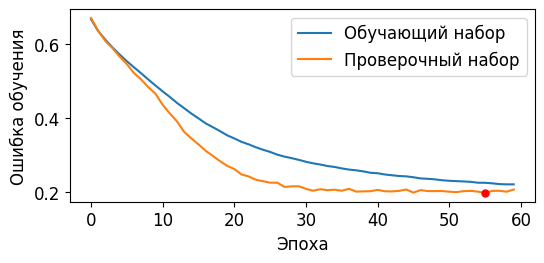

Acc =  0.7302483069977427


Epoch 1: 100%|██████████| 126/126 [00:10<00:00, 12.03it/s]


2023-06-08 00:33:08.054831 Epoch 1, Train loss 0.678, Val loss 0.655, Acc_val = 0.72


Epoch 2: 100%|██████████| 126/126 [00:10<00:00, 12.16it/s]


2023-06-08 00:33:18.886367 Epoch 2, Train loss 0.656, Val loss 0.645, Acc_val = 0.76


Epoch 3: 100%|██████████| 126/126 [00:10<00:00, 12.13it/s]


2023-06-08 00:33:29.750893 Epoch 3, Train loss 0.639, Val loss 0.632, Acc_val = 0.81


Epoch 4: 100%|██████████| 126/126 [00:10<00:00, 12.17it/s]


2023-06-08 00:33:40.575431 Epoch 4, Train loss 0.627, Val loss 0.617, Acc_val = 0.83


Epoch 5: 100%|██████████| 126/126 [00:10<00:00, 12.12it/s]


2023-06-08 00:33:51.442955 Epoch 5, Train loss 0.615, Val loss 0.608, Acc_val = 0.84


Epoch 6: 100%|██████████| 126/126 [00:10<00:00, 12.28it/s]


2023-06-08 00:34:02.174523 Epoch 6, Train loss 0.605, Val loss 0.599, Acc_val = 0.83


Epoch 7: 100%|██████████| 126/126 [00:10<00:00, 12.51it/s]


2023-06-08 00:34:12.713153 Epoch 7, Train loss 0.595, Val loss 0.591, Acc_val = 0.83


Epoch 8: 100%|██████████| 126/126 [00:10<00:00, 12.60it/s]


2023-06-08 00:34:23.184804 Epoch 8, Train loss 0.585, Val loss 0.582, Acc_val = 0.83


Epoch 9: 100%|██████████| 126/126 [00:10<00:00, 12.51it/s]


2023-06-08 00:34:33.716436 Epoch 9, Train loss 0.576, Val loss 0.572, Acc_val = 0.83


Epoch 10: 100%|██████████| 126/126 [00:09<00:00, 12.64it/s]


2023-06-08 00:34:44.157097 Epoch 10, Train loss 0.564, Val loss 0.560, Acc_val = 0.84


Epoch 11: 100%|██████████| 126/126 [00:10<00:00, 12.55it/s]


2023-06-08 00:34:54.661737 Epoch 11, Train loss 0.554, Val loss 0.557, Acc_val = 0.82


Epoch 12: 100%|██████████| 126/126 [00:10<00:00, 12.58it/s]


2023-06-08 00:35:05.136388 Epoch 12, Train loss 0.543, Val loss 0.548, Acc_val = 0.83


Epoch 13: 100%|██████████| 126/126 [00:10<00:00, 12.51it/s]


2023-06-08 00:35:15.665021 Epoch 13, Train loss 0.532, Val loss 0.539, Acc_val = 0.82


Epoch 14: 100%|██████████| 126/126 [00:09<00:00, 12.69it/s]


2023-06-08 00:35:26.058697 Epoch 14, Train loss 0.521, Val loss 0.524, Acc_val = 0.84


Epoch 15: 100%|██████████| 126/126 [00:10<00:00, 12.54it/s]


2023-06-08 00:35:36.568336 Epoch 15, Train loss 0.510, Val loss 0.514, Acc_val = 0.84


Epoch 16: 100%|██████████| 126/126 [00:09<00:00, 12.62it/s]


2023-06-08 00:35:47.014995 Epoch 16, Train loss 0.499, Val loss 0.512, Acc_val = 0.82


Epoch 17: 100%|██████████| 126/126 [00:10<00:00, 12.57it/s]


2023-06-08 00:35:57.499642 Epoch 17, Train loss 0.488, Val loss 0.500, Acc_val = 0.83


Epoch 18: 100%|██████████| 126/126 [00:09<00:00, 12.67it/s]


2023-06-08 00:36:07.902316 Epoch 18, Train loss 0.477, Val loss 0.495, Acc_val = 0.83


Epoch 19: 100%|██████████| 126/126 [00:10<00:00, 12.57it/s]


2023-06-08 00:36:18.391961 Epoch 19, Train loss 0.467, Val loss 0.490, Acc_val = 0.83


Epoch 20: 100%|██████████| 126/126 [00:09<00:00, 12.70it/s]


2023-06-08 00:36:28.767643 Epoch 20, Train loss 0.459, Val loss 0.499, Acc_val = 0.78


Epoch 21: 100%|██████████| 126/126 [00:10<00:00, 12.50it/s]


2023-06-08 00:36:39.307272 Epoch 21, Train loss 0.450, Val loss 0.474, Acc_val = 0.84


Epoch 22: 100%|██████████| 126/126 [00:09<00:00, 12.71it/s]


2023-06-08 00:36:49.670958 Epoch 22, Train loss 0.441, Val loss 0.475, Acc_val = 0.83


Epoch 23: 100%|██████████| 126/126 [00:09<00:00, 12.61it/s]


2023-06-08 00:37:00.121616 Epoch 23, Train loss 0.434, Val loss 0.471, Acc_val = 0.83


Epoch 24: 100%|██████████| 126/126 [00:09<00:00, 12.71it/s]


2023-06-08 00:37:10.494298 Epoch 24, Train loss 0.427, Val loss 0.465, Acc_val = 0.84


Epoch 25: 100%|██████████| 126/126 [00:09<00:00, 12.62it/s]


2023-06-08 00:37:20.931961 Epoch 25, Train loss 0.422, Val loss 0.467, Acc_val = 0.83


Epoch 26: 100%|██████████| 126/126 [00:09<00:00, 12.68it/s]


2023-06-08 00:37:31.325636 Epoch 26, Train loss 0.416, Val loss 0.476, Acc_val = 0.81


Epoch 27: 100%|██████████| 126/126 [00:09<00:00, 12.62it/s]


2023-06-08 00:37:41.760299 Epoch 27, Train loss 0.410, Val loss 0.472, Acc_val = 0.81


Epoch 28: 100%|██████████| 126/126 [00:09<00:00, 12.69it/s]


2023-06-08 00:37:52.140980 Epoch 28, Train loss 0.405, Val loss 0.471, Acc_val = 0.81


Epoch 29: 100%|██████████| 126/126 [00:09<00:00, 12.64it/s]


2023-06-08 00:38:02.564647 Epoch 29, Train loss 0.402, Val loss 0.467, Acc_val = 0.81


Epoch 30: 100%|██████████| 126/126 [00:09<00:00, 12.67it/s]


2023-06-08 00:38:12.962321 Epoch 30, Train loss 0.397, Val loss 0.448, Acc_val = 0.85


Epoch 31: 100%|██████████| 126/126 [00:09<00:00, 12.72it/s]


2023-06-08 00:38:23.363995 Epoch 31, Train loss 0.393, Val loss 0.458, Acc_val = 0.83


Epoch 32: 100%|██████████| 126/126 [00:09<00:00, 12.71it/s]


2023-06-08 00:38:33.725681 Epoch 32, Train loss 0.391, Val loss 0.462, Acc_val = 0.82


Epoch 33: 100%|██████████| 126/126 [00:09<00:00, 12.74it/s]


2023-06-08 00:38:44.066374 Epoch 33, Train loss 0.387, Val loss 0.468, Acc_val = 0.80


Epoch 34: 100%|██████████| 126/126 [00:09<00:00, 12.66it/s]


2023-06-08 00:38:54.471046 Epoch 34, Train loss 0.384, Val loss 0.448, Acc_val = 0.84


Epoch 35: 100%|██████████| 126/126 [00:10<00:00, 12.33it/s]


2023-06-08 00:39:05.136635 Epoch 35, Train loss 0.382, Val loss 0.464, Acc_val = 0.81


Epoch 36: 100%|██████████| 126/126 [00:09<00:00, 12.67it/s]


2023-06-08 00:39:15.534310 Epoch 36, Train loss 0.379, Val loss 0.479, Acc_val = 0.77


Epoch 37: 100%|██████████| 126/126 [00:09<00:00, 12.70it/s]


2023-06-08 00:39:25.905994 Epoch 37, Train loss 0.378, Val loss 0.473, Acc_val = 0.78


Epoch 38: 100%|██████████| 126/126 [00:09<00:00, 12.65it/s]


2023-06-08 00:39:36.320663 Epoch 38, Train loss 0.375, Val loss 0.470, Acc_val = 0.78


Epoch 39: 100%|██████████| 126/126 [00:10<00:00, 12.55it/s]


2023-06-08 00:39:46.807310 Epoch 39, Train loss 0.373, Val loss 0.452, Acc_val = 0.82


Epoch 40: 100%|██████████| 126/126 [00:09<00:00, 12.67it/s]


2023-06-08 00:39:57.211982 Epoch 40, Train loss 0.371, Val loss 0.447, Acc_val = 0.83


Epoch 41: 100%|██████████| 126/126 [00:09<00:00, 12.71it/s]


2023-06-08 00:40:07.572669 Epoch 41, Train loss 0.369, Val loss 0.458, Acc_val = 0.81


Epoch 42: 100%|██████████| 126/126 [00:09<00:00, 12.65it/s]


2023-06-08 00:40:17.980340 Epoch 42, Train loss 0.368, Val loss 0.468, Acc_val = 0.79


Epoch 43: 100%|██████████| 126/126 [00:09<00:00, 12.74it/s]


2023-06-08 00:40:28.320033 Epoch 43, Train loss 0.366, Val loss 0.457, Acc_val = 0.81


Epoch 44: 100%|██████████| 126/126 [00:09<00:00, 12.67it/s]


2023-06-08 00:40:38.713710 Epoch 44, Train loss 0.366, Val loss 0.455, Acc_val = 0.81


Epoch 45: 100%|██████████| 126/126 [00:09<00:00, 12.69it/s]


2023-06-08 00:40:49.095390 Epoch 45, Train loss 0.364, Val loss 0.459, Acc_val = 0.80


Epoch 46: 100%|██████████| 126/126 [00:09<00:00, 12.71it/s]


2023-06-08 00:40:59.461075 Epoch 46, Train loss 0.364, Val loss 0.444, Acc_val = 0.83


Epoch 47: 100%|██████████| 126/126 [00:09<00:00, 12.74it/s]


2023-06-08 00:41:09.800768 Epoch 47, Train loss 0.362, Val loss 0.460, Acc_val = 0.80


Epoch 48: 100%|██████████| 126/126 [00:09<00:00, 12.73it/s]


2023-06-08 00:41:20.148459 Epoch 48, Train loss 0.360, Val loss 0.473, Acc_val = 0.77


Epoch 49: 100%|██████████| 126/126 [00:09<00:00, 12.76it/s]


2023-06-08 00:41:30.475157 Epoch 49, Train loss 0.359, Val loss 0.460, Acc_val = 0.80


Epoch 50: 100%|██████████| 126/126 [00:09<00:00, 12.71it/s]


2023-06-08 00:41:40.833844 Epoch 50, Train loss 0.360, Val loss 0.452, Acc_val = 0.81


Epoch 51: 100%|██████████| 126/126 [00:09<00:00, 12.80it/s]


2023-06-08 00:41:51.122553 Epoch 51, Train loss 0.358, Val loss 0.466, Acc_val = 0.79


Epoch 52: 100%|██████████| 126/126 [00:10<00:00, 12.35it/s]


2023-06-08 00:42:01.771148 Epoch 52, Train loss 0.356, Val loss 0.454, Acc_val = 0.81


Epoch 53: 100%|██████████| 126/126 [00:09<00:00, 12.74it/s]


2023-06-08 00:42:12.105843 Epoch 53, Train loss 0.356, Val loss 0.455, Acc_val = 0.81


Epoch 54: 100%|██████████| 126/126 [00:09<00:00, 12.72it/s]


2023-06-08 00:42:22.464530 Epoch 54, Train loss 0.353, Val loss 0.468, Acc_val = 0.78


Epoch 55: 100%|██████████| 126/126 [00:09<00:00, 12.73it/s]


2023-06-08 00:42:32.805223 Epoch 55, Train loss 0.353, Val loss 0.456, Acc_val = 0.80


Epoch 56: 100%|██████████| 126/126 [00:09<00:00, 12.71it/s]


2023-06-08 00:42:43.166909 Epoch 56, Train loss 0.353, Val loss 0.473, Acc_val = 0.77


Epoch 57: 100%|██████████| 126/126 [00:09<00:00, 12.71it/s]


2023-06-08 00:42:53.530595 Epoch 57, Train loss 0.352, Val loss 0.460, Acc_val = 0.80


Epoch 58: 100%|██████████| 126/126 [00:09<00:00, 12.71it/s]


2023-06-08 00:43:03.889283 Epoch 58, Train loss 0.353, Val loss 0.469, Acc_val = 0.78


Epoch 59: 100%|██████████| 126/126 [00:09<00:00, 12.73it/s]


2023-06-08 00:43:14.239972 Epoch 59, Train loss 0.350, Val loss 0.452, Acc_val = 0.81


Epoch 60: 100%|██████████| 126/126 [00:09<00:00, 12.72it/s]


2023-06-08 00:43:24.593662 Epoch 60, Train loss 0.349, Val loss 0.465, Acc_val = 0.79


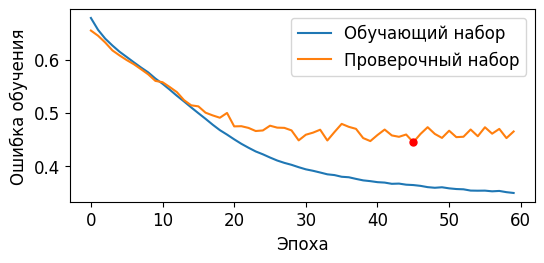

Acc =  0.8214285714285714
Final results
60 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.73) 0.81 / 0.79 / 0.63 / 0.73 / 0.82


C:\Users\Tanya\AppData\Local\Temp\ipykernel_10624\609669942.py:101: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(folds),i+1)


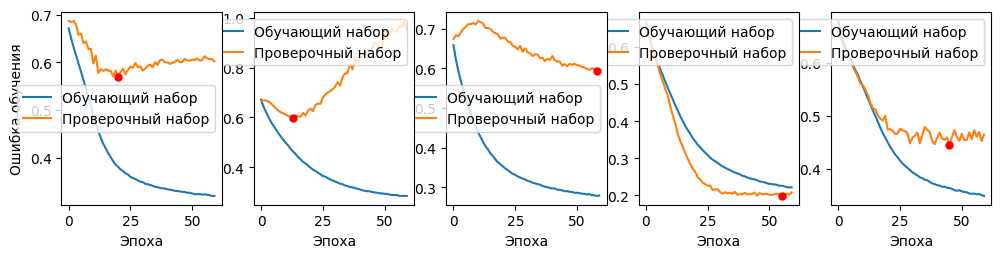

In [8]:
import os
model_dir = 'model_backup'
if not os.path.exists(model_dir):  
  os.makedirs(model_dir)

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()
# model = ALS_CNN()

# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 40 epochs. Acc_sk = 0.70 (Sens = 0.74 / Spec = 0.66) 0.68 / 0.86 / 0.52 / 0.76 / 0.77
# self.layer1_filt = 2 (before 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.66 (Sens = 0.62 / Spec = 0.70) 0.68 / 0.55 / 0.57 / 0.62 / 0.88
# max_pool_width = 4 (before 1)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.59 (Sens = 0.53 / Spec = 0.65) 0.65 / 0.50 / 0.56 / 0.61 / 0.63
# self.layer1_filt = 4 + max_pool_width = 4 + lf1_height, lf1_width = 29,43
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.65 (Sens = 0.61 / Spec = 0.69) 0.61 / 0.62 / 0.60 / 0.65 / 0.75 (good behaviour)
# mf2_height,mf2_width = 15,43 (before 15x17)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.72 (Sens = 0.73 / Spec = 0.70) 0.71 / 0.69 / 0.53 / 0.75 / 0.90
# hf4_height,hf4_width = 15,43 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.76 / Spec = 0.64) 0.73 / 0.66 / 0.53 / 0.73 / 0.86
# hf4_height,hf4_width = 15,31 (before 15x43)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.77 / Spec = 0.64) 0.67 / 0.79 / 0.51 / 0.68 / 0.89
# hf3_height,hf3_width = 13,27 (before 11x11)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.70) 0.78 / 0.86 / 0.53 / 0.74 / 0.89
# mf_height,mf_width = 13,27 (before 3x3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.77 / Spec = 0.75) 0.78 / 0.82 / 0.62 / 0.73 / 0.88
# lf3_height, lf3_width = 13,27 (3x7)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.75 (Sens = 0.76 / Spec = 0.73) 0.72 / 0.81 / 0.65 / 0.72 / 0.87
# lf3_height, lf3_width = 25,39 (13x27)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.72 (Sens = 0.73 / Spec = 0.72) 0.65 / 0.67 / 0.62 / 0.74 / 0.92  (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.69 / 0.79 / 0.63 / 0.71 / 0.88
# lf3_height, lf3_width = 5,11
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.72) 0.63 / 0.82 / 0.64 / 0.75 / 0.88
# model with diff input. Now there is 2 input chanells: x and x_diff
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.66 / Spec = 0.76) 0.69 / 0.66 / 0.58 / 0.67 / 0.91
# self.layer1_filt = 6 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.78 (Sens = 0.80 / Spec = 0.76) 0.70 / 0.80 / 0.69 / 0.74 / 0.93
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.5) # 30 epochs. Acc_sk = 0.77 (Sens = 0.79 / Spec = 0.74) 0.71 / 0.79 / 0.65 / 0.76 / 0.90
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.3) # 30 epochs. Acc_sk = 0.77 (Sens = 0.76 / Spec = 0.77) 0.70 / 0.74 / 0.68 / 0.72 / 0.94
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 20 epochs. Acc_sk = 0.71 (Sens = 0.69 / Spec = 0.74) 0.66 / 0.80 / 0.64 / 0.71 / 0.81
# hf_height,hf_width = 9,9 (before 3x3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.76 / Spec = 0.75) 0.66 / 0.82 / 0.61 / 0.74 / 0.93
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.75 (Sens = 0.75 / Spec = 0.74) 0.75 / 0.78 / 0.62 / 0.72 / 0.87
# hf_height,hf_width = 3,3 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 35 epochs. Acc_sk = 0.77 (Sens = 0.78 / Spec = 0.75) 0.70 / 0.82 / 0.66 / 0.75 / 0.89 (32 min)
# big context on each subband
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.68 (Sens = 0.72 / Spec = 0.64) 0.60 / 0.80 / 0.57 / 0.70 / 0.78
# hf2_height,hf2_width = 13,27 (15x31)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.71 / Spec = 0.67) 0.66 / 0.73 / 0.57 / 0.68 / 0.83
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.76 / Spec = 0.70) 0.68 / 0.85 / 0.59 / 0.75 / 0.83
# mf2_height,mf2_width = 11,31 (15x43)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.72 / Spec = 0.67) 0.62 / 0.87 / 0.57 / 0.67 / 0.86
# Val set balanced + golden section convs
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.75 / Spec = 0.76) 0.68 / 0.78 / 0.70 / 0.71 / 0.87
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 30 epochs. Acc_sk = 0.75 (Sens = 0.75 / Spec = 0.75) 0.71 / 0.82 / 0.71 / 0.72 / 0.82
# self.layer1_filt = 2 (before 1)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.74 (Sens = 0.74 / Spec = 0.74) 0.68 / 0.73 / 0.63 / 0.71 / 0.88
# self.layer1_filt = 1 (before 2)
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.74 (Sens = 0.71 / Spec = 0.76) 0.75 / 0.83 / 0.69 / 0.67 / 0.79
# optimizer = optim.Adam(model.parameters(),lr=5e-5, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.74 (Sens = 0.73 / Spec = 0.76) 0.75 / 0.85 / 0.67 / 0.67 / 0.82
# self.layer1_filt = 2 (before 1)
# optimizer = optim.Adam(model.parameters(),lr=5e-5, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.73 (Sens = 0.72 / Spec = 0.75) 0.76 / 0.75 / 0.65 / 0.71 / 0.78
# self.layer1_filt = 1 (before 2) + lf4_height, lf4_width = 11,19 (9x11 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.67 (Sens = 0.68 / Spec = 0.66) 0.68 / 0.81 / 0.53 / 0.62 / 0.70
# lf4_height, lf4_width = 9,11 (11x19 before) + lf3_height, lf3_width = 9,11 (11x19 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.74 (Sens = 0.69 / Spec = 0.79) 0.72 / 0.81 / 0.65 / 0.65 / 0.83
# lf3_height, lf3_width = 11,19 (return). Default convs
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)
# ...
# self.layer1_filt = 4 (before 3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.78 (Sens = 0.77 / Spec = 0.79) 0.80 / 0.83 / 0.68 / 0.75 / 0.86
# self.layer1_filt_hf = 1 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.72 / Spec = 0.74) 0.73 / 0.81 / 0.64 / 0.70 / 0.83
# self.layer1_filt_hf = 4 (before 1) + mf5_height,mf5_width =  15,9
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.78 (Sens = 0.78 / Spec = 0.77) 0.78 / 0.82 / 0.60 / 0.72 / 0.93
# best model selection problem fixed
# self.layer1_filt = 1 + self.layer1_filt_hf = 1
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.67 (Sens = 0.67 / Spec = 0.67) 0.65 / 0.72 / 0.48 / 0.66 / 0.85
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.72 (Sens = 0.72 / Spec = 0.72) 0.75 / 0.77 / 0.48 / 0.70 / 0.92
# self.layer1_filt = 4 + self.layer1_filt_hf = 1
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.77 (Sens = 0.79 / Spec = 0.74) 0.75 / 0.82 / 0.61 / 0.72 / 0.90
# self.layer1_filt_hf = 4
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.79 (Sens = 0.82 / Spec = 0.76) 0.81 / 0.81 / 0.61 / 0.75 / 0.93
# conv_lf5 and conv_mf5 removed
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.82 / Spec = 0.70) 0.79 / 0.79 / 0.51 / 0.73 / 0.94
# ...
# # lf5_height, lf5_width = 31,19 (5th convs in LF subband added)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 0 epochs. Acc_sk = 0.81 (Sens = 0.81 / Spec = 0.80) 0.81 / 0.80 / 0.72 / 0.71 / 0.93
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)  # 60 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.73) 0.81 / 0.79 / 0.63 / 0.73 / 0.82
k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=60)

In [60]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

#Test 4
# x = torch.randn(3)
# x3 = torch.cat((x, x, x), 0)
# print(x3)

#Test 5
A = np.random.random((2,3))
print(A.shape)
A = A.reshape((1,A.shape[0],A.shape[1]))
print(A.shape)

torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
(2, 3)
(1, 2, 3)


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
